# Introduction

Predict North America video game sales with a dataset from [Kaggle](https://www.kaggle.com/gregorut/videogamesales).

Personal goal is to use Python for data cleaning and classical machine learning, so there will be a good amount of notes per method used. There will be some exploratory analysss in this notebook, but it won't go in too depth.

*Note: Codes may also come from other sources for practice/workflow 

## What else do I hope to achieve from this?

Develop a stronger understanding in experimental design before developing prediction models. It's the idea of the laying out of a detailed experimental plan in advance of doing the experiment.
- How should we best represent splitting the data?
- How do we control the environment to best mimic a real-world study?

Develop a stronger understanding using Python functions and methods in the entire modeling lifecycle after data preparation. 
- What's best practice? 
- Should I create a bunch of wrapper functions to automate everything? 
- Should I start building in a granular form first? 
- Do I understand the algorithms being implemented?

## Dataset

This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a scrape of vgchartz.com.

Note: This could be another project where I could modify the scraper for practice.

__Feature Descriptions:__

1. Rank - Ranking of overall sales

1. Name - The games name

1. Platform - Platform of the games release

1. Year - Year of the game's release

1. Genre - Genre of the game

1. Publisher - Publisher of the game

1. NA_Sales - Sales in North America (in millions)

1. EU_Sales - Sales in Europe (in millions)

1. JP_Sales - Sales in Japan (in millions)

1. Other_Sales - Sales in the rest of the world (in millions)

1. Global_Sales - Total worldwide sales.


## Framing the problem

Can you predict North America video game sales?

## Method of Evaluation

Since we are predicting a price, this will be a regression problem. We will use linear algorithms like linear regression, ridge regression, lasso regression, elastic-net regression and non-linear algorithms like random forest, gradient boosting, and a stacking method.

The evaluation metric we will be using is __Root-Mean-Squared_error (RMSE)__ between actual sales and the predicted sales. RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

__Why RMSE over mean-squared-error (MAE)?__ Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

Here's a picture of the RMSE formula below.

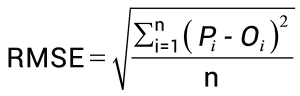

In [241]:
from PIL import Image
Image.open('..\\Images\\10-rmse.png')

## Modeling Framework

1. Framing the problem
    - What are we trying to solve?
    - Understand what's the problem here and ask questions
    - What type of problem are we trying to solve?
        - Classification, regression, etc.
        - Types of algorithms specified for possible use
2. Collecting relevant information and data
    - What type of data do we have?
        - Databases, scraped data, API data, etc.
    - What other data requirements are there?
    - What is considered a success for this problem?
    - What libraries do we need?
        - How do we know our models are good?
3. Process for analysis (preprocessing & cleaning)
    - How does the data structure and distribution look like?
    - Is the data usable right away? 
    - Can the data be plotted?
    - What changes do we need to make the data usable if it's not already?
4. Exploratory data analysis
    - How does the data look like?
    - Are there any patterns?
        - Identify any summary statistics, plotting, counting, etc.
    - Familiarize yourself with the data
    - Basically the step to help you get to know the data better
5. Feature engineering (applied machine learning)
    - Can we create more data (features) that will be helpful for our models?
    - "... re-working of predictors is more of an art, requiring the right tools and experience to find better predictor representations" - Max Kuhn
6. Statistical analysis
    - Univariate, bivariate, multivariate analysis
        - Analysis of a single feature
        - Analysis of two features and their relationships
        - Analysis of data collected on more than one dependent variable and their relationships (PCA, PLS)
7. Modeling & Scoring
    - Splitting the data into train and test sets
        - Always make sure you have a completely separate data set to test your final model on after hyperparameter tuning and training has been done
        - Think about your experimental design beforehand so that you minimize unrelated sources of variation and reduce as much data leakage (if any) as possible
    - Standardizing the data to be on similar scales
    - Create baseline & pre-tuned models
    - Cross-validate the models
    - Hyperparameter tuning
    - Create cross-validated tuned models using best hyperparameters
    - Compare models
8. Evaluation
    - How accurate are the models?
        - Are the models overfitting or underfitting?
    - What evaluation metric are we using?
    - Is the final model good enough?
    - Which features are important?
    - Iterate steps with feature selection
9. Extra
    - Create train vs. cross-validating learning curves per size
10. Ending Notes
    - Notes on algorithms used, models created, ways to improve performances

## Collecting relevant data

In [242]:
# Set directory
import os
path = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\Python\\MachineLearning\\Data'

# Move to directory with the data
os.chdir(path)

# Check
os.getcwd()
os.listdir()

['01-ign.csv',
 '02-winequality-red.csv',
 '02-winequality-white.csv',
 '03-thanksgiving-2015-poll-data.csv',
 '05-ibm-sales-loss.csv',
 '07-test.csv',
 '07-train.csv',
 '09-house-regression-env.db',
 '09-house-test.csv',
 '09-house-train.csv',
 '10-vgsales.csv',
 '11-diabetes.csv']

## Import libraries

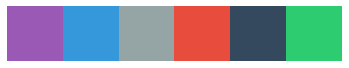

In [243]:
# Toolbox
import pandas as pd
import pandas_profiling
import numpy as np
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm, skew, poisson, boxcox_normmax
from scipy.special import boxcox1p
from scipy import stats

# Misc
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite color for use: #34995e

## Import data

In [244]:
data = pd.read_csv('10-vgsales.csv')

## Preprocess & Clean

Let's take a look at the data and see how it's structured. We will also be lookin for missing values as well to get an idea how complete the data is and create some summary diagnostics/plots. The less missing values the better and if they are missing, why are they missing?

In summary, some of the questions we try to answer here:
- Are we able to use the data right away?
- Are there any nul values?
- How clean is the data?

Here are some basic functions we can use below.

In [137]:
'''

Some functions to start off with:

train.sample()                                           
train.describe()
    train.describe(include=['O'])
    train.describe(include='all')
train.head()
train.tail()
train.value_counts().sum()
train.isnull().sum()
train.count()
train.fillna()
    train.fillna(train[col].mode(), inplace=True)
train.mean()
train.median()
train.mode()
train.shape
train.info()

'''
print('')

In [138]:
# Top 5 rows
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [139]:
# Shape of the data
data.shape

(16598, 11)

## Splitting data

Since the goal of looking at this dataset is to predict video game sales, we need to have at least 1 train set and 1 test set so we will split the data here. We are splitting the data at the very beginning, because we attempt to remove the possibility of data leakage as much as we can when developing predictive models is the goal here.

__Data leakage__ - when information from outside the training dataset is used to create the model

Data leakage can cause you to create overly optimistic if not completely invalid predictive models because additional information can allow the model to learn or know something that it otherwise would not know, which will in turn invalidate the estimated performance of the model being constructed. - [MLM Link](https://machinelearningmastery.com/data-leakage-machine-learning/)

In other words, you know information of your test beforehand and then attempt to train (study & learn) on that same test and then validate your train results (time studying and what you have learned) on a "new" test data (the same dataset you learned from). So did you really learn something?

Techniques to minimize data leakage when building models
1. Perform data preparation within your cross-validation folds
    - One solution for this, we can re-prep the data within your cross validation folds including tasks like feature selection, outlier removal, encoding, feature scaling and projection methods for dimensionality reduction, and more
2. Hold back a validation dataset for final sanity check of your developed models
    - This approach splits your training dataset into 2 sets (1 train and 1 validation) and then save the validation dataset for use after the models have been created
    - Once created, validate the performance on the validation set 

Common data preparation issues
1. Normalizing or standardization your entire dataset and then estimating the performance of your model using cross-validation
    - When this happens, the test data's information is being added into the training information so when we start testing, it's not a true representation of unknown data
    - An example is when you attempt to rescale the data on the same distribution of data, which includes the test set, and then use those values as inputs in your model

## Train and test sets

In [140]:
# Split dependent and independent variables
y = data['NA_Sales']
X = data.drop(['NA_Sales'], axis=1)

# Shuffle the data and then split the data into train and test sets
# Method 1: Shuffling - most recommended method to save time; drawback includes list ordering is lost
# Method 2: Sampling - creates a new shuffled list and returns it rather than disturbing the order of original list
from sklearn.utils import shuffle
shuffled_data = shuffle(data, random_state=100).reset_index()

In [141]:
# Split the data into train and test sets
print('75% of the data size = ', (round(len(data)*0.75, 0)))
train = shuffled_data[0:12448]
test = shuffled_data[12448:len(shuffled_data)]

75% of the data size =  12448.0


In [142]:
# Get data shape, info, columns, & dimensions
print ("*"*45)
print('********** train shape: ' + str(train.shape) + '*'*10)
print (train.info())
print ("*"*43)
print('********** test shape: ' + str(test.shape) + '*'*10)

*********************************************
********** train shape: (12448, 12)**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12448 entries, 0 to 12447
Data columns (total 12 columns):
index           12448 non-null int64
Rank            12448 non-null int64
Name            12448 non-null object
Platform        12448 non-null object
Year            12247 non-null float64
Genre           12448 non-null object
Publisher       12401 non-null object
NA_Sales        12448 non-null float64
EU_Sales        12448 non-null float64
JP_Sales        12448 non-null float64
Other_Sales     12448 non-null float64
Global_Sales    12448 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.1+ MB
None
*******************************************
********** test shape: (4150, 12)**********


We split the data early on using the train_test_split() function with 75% of the data going into the training set and 25% of the data going into the test set. Then we combined the y and X train data together so we have the full train population.

Now, we will not touch the test data for any reason unless we are scaling or creating new features. Only scale and create features based on the training set.

### Some methods to combine/add dataframe data
If we were combining two dataframes (appending rows), we could use a concat() method:
- pd.concat([dataframe_1, dataframe_2], ignore_index=True)

If we were combining two dataframes (appending columns), we could use a merge() method:
- pd.merge(dataframe_1, dataframe_2, left_on='id', right_on='id')
- pd.merge(dataframe_1, dataframe_2, on='id', how='left')

If we wanted to add an additional row of data, we could use an append() method:
- new_row_data = pd.Series([1,2,3,4], index=['id', 'col1', col2'...]]
- dataframe_1.append(new_row_data, ignore_index=True)

## Null values

Are there any null values? Let's show column names with any null data values.

In [143]:
# Get nulls
null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)*100/len(train), 2), columns=['Null Data Pct'])

# Combine the two dataframes (axis=1) with column names using the keys parameter
null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

# Get null features only
all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

# Print
print('There are', len(all_nulls), 'columns with missing values.')
all_nulls

There are 2 columns with missing values.


,Null Data Count,Null Data Pct
Year,201,1.61
Publisher,47,0.38


## Plotting the nulls

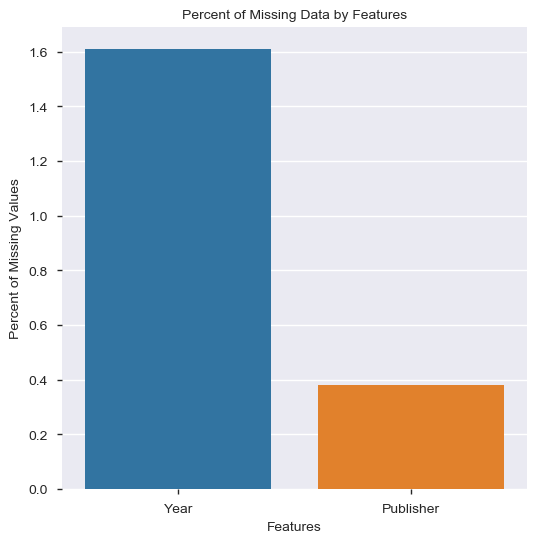

In [144]:
# Create figure space
fig = plt.figure(figsize=(6, 6))

# Create bar plot
fig = sns.barplot(x=all_nulls.index,
                  y='Null Data Pct',
                  data=all_nulls)

# Set plot features (seaborn we use set methods vs. plt methods for matplotlib)
plt.xticks(rotation='0')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of Missing Values', fontsize=10)
plt.title('Percent of Missing Data by Features', fontsize=10)
plt.show()

Looks like we have a total of 2 features that have missing values. We can try to explore the features to see why it would have nulls in the first place, but for the sake of this notebook, we will just remove them for now. Also, the plot may be a little misleading because the bars are very large but there really is only less than 2 percent of missing data so we will rescale it in the next plot.

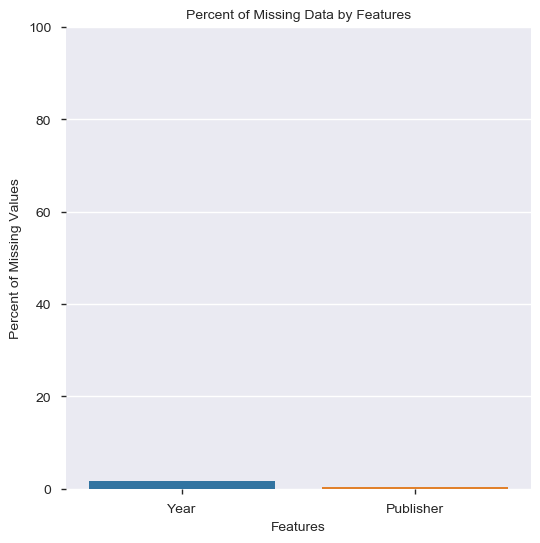

In [145]:
# Create figure space
fig = plt.figure(figsize=(6, 6))

# Create bar plot
fig = sns.barplot(x=all_nulls.index,
                  y='Null Data Pct',
                  data=all_nulls)

# Set plot features (seaborn we use set methods vs. plt methods for matplotlib)
plt.xticks(rotation='0')
plt.ylim(0,100)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of Missing Values', fontsize=10)
plt.title('Percent of Missing Data by Features', fontsize=10)
plt.show()

Compare the differences. Data visualization is a crucial soft skill to have as we want to present the data to be as accurate and compelling as possible for our audience to perceive the idea of what we are attempting to inform them of. Hopefully our audience would be more engaged in this after seeing the second plot and will remember the size gap between the two. In this case, there isn't a lot of missing values based on this plot above. 

### Data storytelling 
Data storytelling can be a whole notebook by itself on best practices on what can be done to craft a more compelling story behind our analyses to uncover insights and drive action. Remember that all the work we do is really just a subset of a giant interdisciplinary field and for me, this subset involves behavioral economics (we are all irrational), psychology (behavioral, neuroscience), decision science, and much more!

Take a look at some of these links about data storytelling/data visualization:
- [Storytellingwithdata](http://www.storytellingwithdata.com/)
- [Data Storytelling as an essential skill](https://www.forbes.com/sites/brentdykes/2016/03/31/data-storytelling-the-essential-data-science-skill-everyone-needs/#6e2ba8e652ad)
- [Few examples](https://twooctobers.com/blog/8-data-storytelling-concepts-with-examples/)

### Ways to clean up null values

There are several methods on how to handle missing values as there are always some instances where a particular value is absent for real-world data. Reasons like corrupt date, failure to load the information correctly, never inputting the data values in the first place, or other invalid methods of data collections are all ways values are missing. It's extremely helpful to know a few methods on how to handle NaN values. Pandas library also provides a dropna() function that can be used to drop columns or rows of missing data.

Some methods of dealing with null values below:
1. Removing the entire row with the missing value using an index or dropna() function
    - Use the inplace parameter, if True, do operation inplace and return None
    - Use the axis parameter, drop labels from the index level(then 0) or column level (then 1)
2. Impute the missing value using fillna()
    - Constant value that has meaning within the domain; ex: 0 for a missing numerical value or 'Missing' for categorical
    - Value from another randomly selected record (could be completely random, or have some business insight to add)
    - Use the mean, median, or mode value of the column
    - Estimate a new value using an algorithm (ex: random forest)
3. Binning
    - Grouping the values together either within a numerical range or based on a specific condition
    - Issue from this is that you may lose information from this method
4. Ignore and leave it as it is
    - Sometimes it's useful to know that there is a missing value

## Dependent feature distribution

Let's take a look at the distribution shape of our NA_Sales feature (dependent variable, y variable). We can also do a log transformation on the variable to ensure that errors predicting expensive games on smaller consoles vs bigger consoles will affect our scoring method equally across all games.

In [146]:
# Create a dataframe to store y and log(y) variables
na_sales_df = pd.concat([train.NA_Sales, np.log(train.NA_Sales+1).rename('Log_NA_Sales')],
                        axis=1, names=['NA_Sales', 'Log_NA_Sales'])
# Check
na_sales_df.head()

,NA_Sales,Log_NA_Sales
0,0.14,0.131028
1,0.05,0.048790
2,0.12,0.113329
3,0.54,0.431782
4,0.00,0.000000


### Plot NA_Sales and Log_NA_Sales distributions

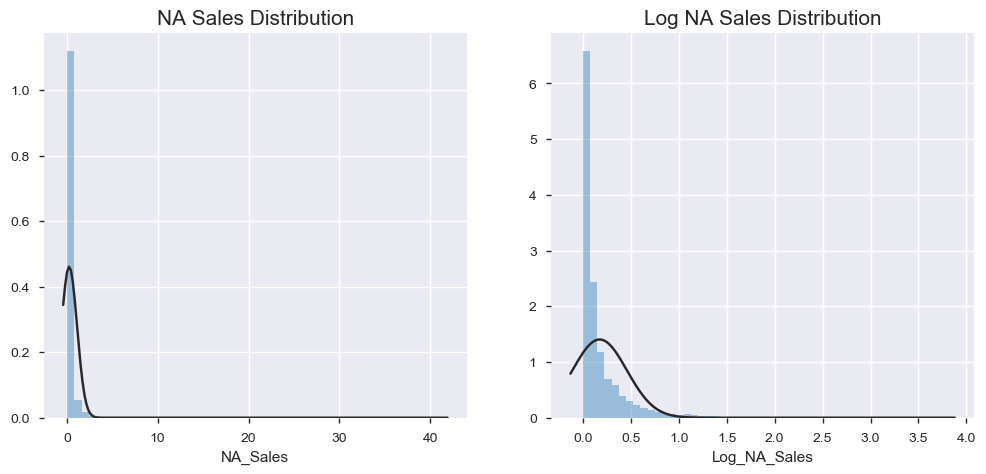

In [147]:
# Create figure space
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)

### Create histograms
## Use flatten() for sns objects:
# The solution is to expand/flatten make your 2d axes object and then directly iterate over it which 
# gives you individual subplot, one at a time.
ax1 = sns.distplot(na_sales_df.NA_Sales, kde=False, fit=norm, ax=ax.flatten()[0])
ax2 = sns.distplot(na_sales_df.Log_NA_Sales, kde=False, fit=norm, ax=ax.flatten()[1])

# Set plot features
ax1.set_title('NA Sales Distribution', fontsize=15)
ax2.set_title('Log NA Sales Distribution', fontsize=15)
plt.show()

### Distribution shapes
A left-skewed distribution has a long left tail. Left-skewed distributions are also called negatively-skewed distributions, because there is a long tail in the negative direction on the number line. The mean is also to the left of the peak which is less than the median.

A right-skewed distribution has a long right tail. Right-skewed distributions are also called positive-skew distributions since there is a long tail in the positive direction on the number line. The mean is also to the right of the peak which is larger than the median.

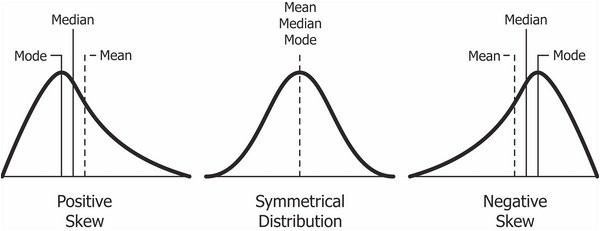

In [148]:
Image.open('..\\Images\\10-distribution.jpg')

The distribution at a glance does not pass the normal test. The shape of the distribution is positively skewed so there is a right sided tail (shown above in a sample picture). This usually indicates that the mean value is larger than the median value as well. If we can't bring the data to normality then we will not be able to use certain statistical tests like t-tests or ANOVA to compare means. 

Let's see what outliers are there and figure out if we can remove them or not to make the data more normal. Removing data is not always a good thing but it can be a short-term solution when there is a justified reason.

In [149]:
# Get outliers based on plot
train[train.NA_Sales>10]

,index,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
404,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
737,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
2476,8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
2834,15,16,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
5659,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
5906,21,22,Super Mario Land,GB,1989.0,Platform,Nintendo,10.83,2.71,4.18,0.42,18.14
10361,5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
11336,4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
11527,9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31
12279,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


Actually there are not a lot of NA Sales above $10M. There are in fact just 10 rows of data, these are the extremely popular games in America. Now should we remove them? What would happen to the distribution if we remove them and will this help our models in the end?

Let's plot it without the outliers first and see.

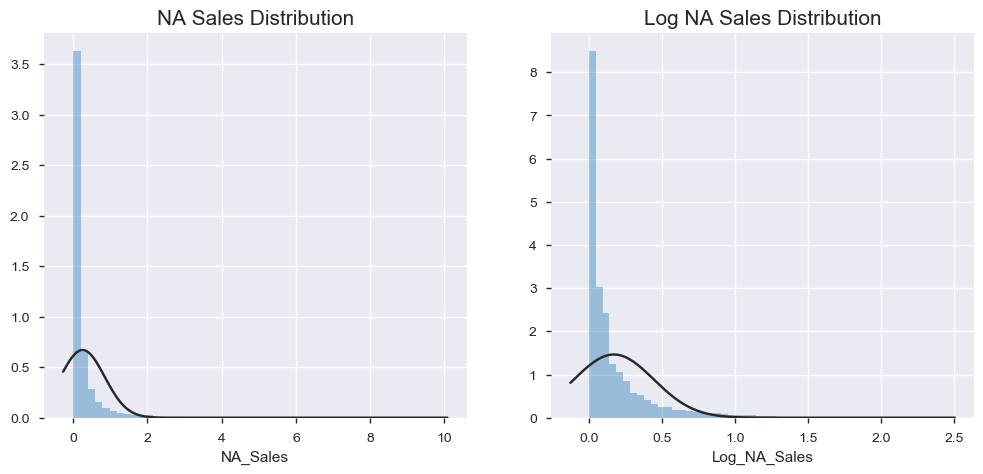

In [150]:
# Create figure space
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)

## Create histograms
# Use flatten() for sns objects
ax1 = sns.distplot(na_sales_df[na_sales_df.NA_Sales<10].NA_Sales, kde=False, fit=norm, ax=ax.flatten()[0])
ax2 = sns.distplot(na_sales_df[na_sales_df.NA_Sales<10].Log_NA_Sales, kde=False, fit=norm, ax=ax.flatten()[1])

# Set plot features
ax1.set_title('NA Sales Distribution', fontsize=15)
ax2.set_title('Log NA Sales Distribution', fontsize=15)
plt.show()

There is still a large skew. Let's see how many are over $5M in sales.

In [151]:
# Get outliers based on plot
train[train.NA_Sales>5].NA_Sales.value_counts().sum()
train[train.NA_Sales>5].sort_values(by='NA_Sales', ascending=False)

,index,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
5659,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
404,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
11527,9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31
10361,5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
12279,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
737,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
2834,15,16,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
2476,8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
11336,4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5906,21,22,Super Mario Land,GB,1989.0,Platform,Nintendo,10.83,2.71,4.18,0.42,18.14


There are 32 games above $5M. Let's see how the distribution looks like without them.

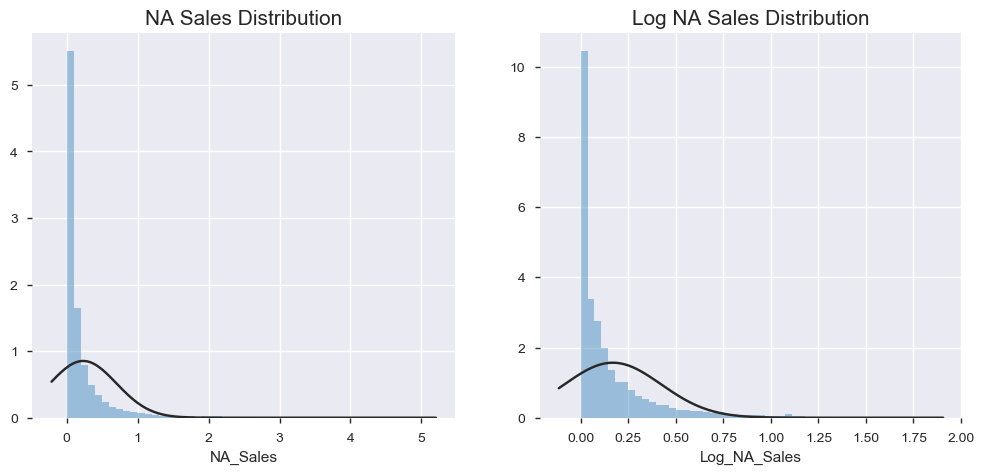

In [152]:
# Create figure space
fig, ax = plt.subplots(figsize=(12, 5), ncols=2, nrows=1)

# Create histograms and use flatten() for sns plot objects
ax1 = sns.distplot(na_sales_df[na_sales_df.NA_Sales<5].NA_Sales, kde=False, fit=norm, ax=ax.flatten()[0])
ax2 = sns.distplot(na_sales_df[na_sales_df.NA_Sales<5].Log_NA_Sales, kde=False, fit=norm, ax=ax.flatten()[1])

# Set plot features
ax1.set_title('NA Sales Distribution', fontsize=15)
ax2.set_title('Log NA Sales Distribution', fontsize=15)
plt.show()

After replotting it three times, and seeing the distributions made me realize that this shape looks more like a poisson distribution vs. a normal distribution. The starting point of the distribution would always be at a minimum of zero, but is it a poisson distribution?

__What is a Poisson distribution?__
- "A [Poisson distribution](https://www.investopedia.com/terms/p/poisson-distribution.asp) is a statistical distribution showing the likely number of times that an event will occur within a specified period of time. It is used for independent events which occur at a constant rate within a given interval of time. The Poisson distribution is a discrete function, meaning that the event can only be measured as occurring or not as occurring, meaning the variable can only be measured in whole numbers. Fractional occurrences of the event are not a part of the model."

If this was normally distributed, then this would be the mean and standard deviation.


 mu = 0.1753 and sigma = 0.2840



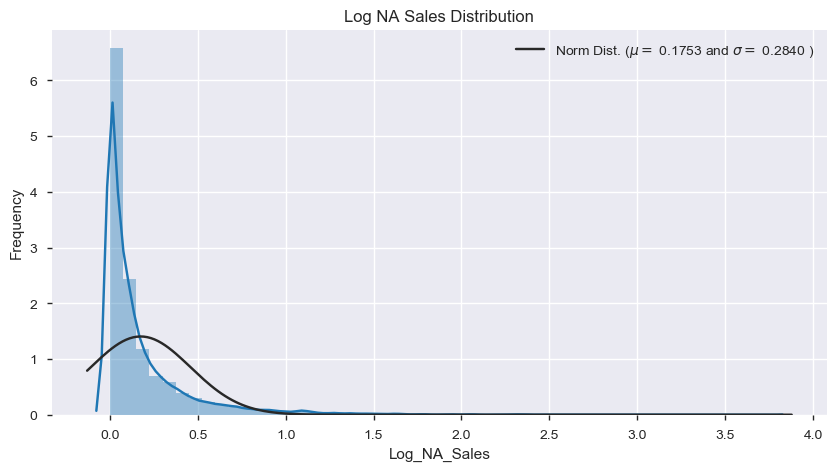

In [153]:
# Create figure space
plt.figure(figsize=(10,5))

# Create plot
sns.distplot(na_sales_df.Log_NA_Sales , fit=norm)

# Get the fitted parameters (feels off without the params somewhere visible)
mu, sigma = norm.fit(na_sales_df.Log_NA_Sales)
print( '\n mu = {:.4f} and sigma = {:.4f}\n'.format(mu, sigma))

# Plot distribution
plt.legend(['Norm Dist. ($\mu=$ {:.4f} and $\sigma=$ {:.4f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log NA Sales Distribution')
plt.show()

Let's remove any sales over $10M.

In [154]:
train = train[train.NA_Sales<10]
train.shape

(12438, 12)

In [155]:
# Skewness and kurtosis
print('Skewness: %f' % train.NA_Sales.skew())
print('Kurtosis: %f' % train.NA_Sales.kurt())

Skewness: 7.084685
Kurtosis: 75.247707


### Skewness

For normally distributed data, the skewness should be close to 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution (positive) as shown above.

### Kurtosis

Kurtosis is the measure of the combined weight of the tails of the distribution relative to the center of the distribution. 

### What to do now with the distribution?

Since even with a log transformation, the data distribution is not going to be normal. It would be better to use non-parametric methods to model the data vs. parametric methods but we will still start off later with a linear regression because it's simple.

Now let's add in our new feature that we will be using as our dependent variable.

In [156]:
# Return the natural logarithm of one plus the input array, element-wise.
train['Log_NA_Sales'] = np.log1p(train.NA_Sales)
test['Log_NA_Sales'] = np.log1p(test.NA_Sales)

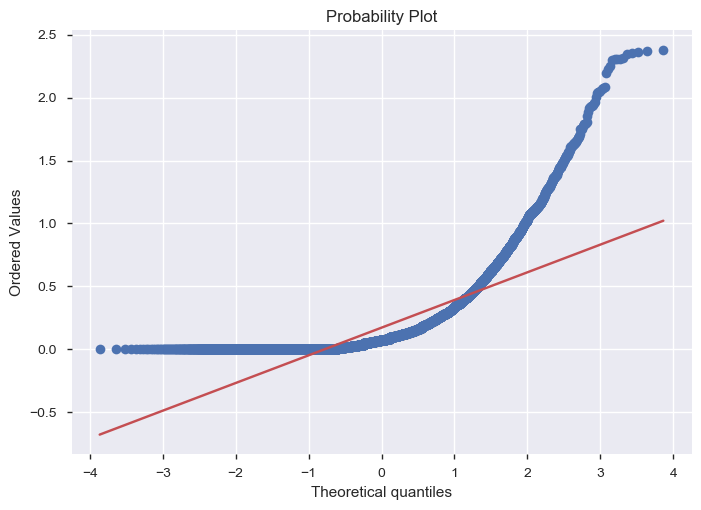

In [157]:
# Just to verify using the QQ-plot to show non-normality
stats.probplot(train['Log_NA_Sales'], plot=plt)
plt.show();

To meet the linear assumptions, we need this qq-plot to be closer to a diagonal shape. We see that it's curve at the tails which means it's not quite as linear as we want it to be even though the variable is in log form.

## Exploratory Data Analysis

Now that we've taken the look at our dependent variable, let's create some quick grouped plots and use pandas_profiling to save time.

### Platform feature

Which platforms have the highest sales?

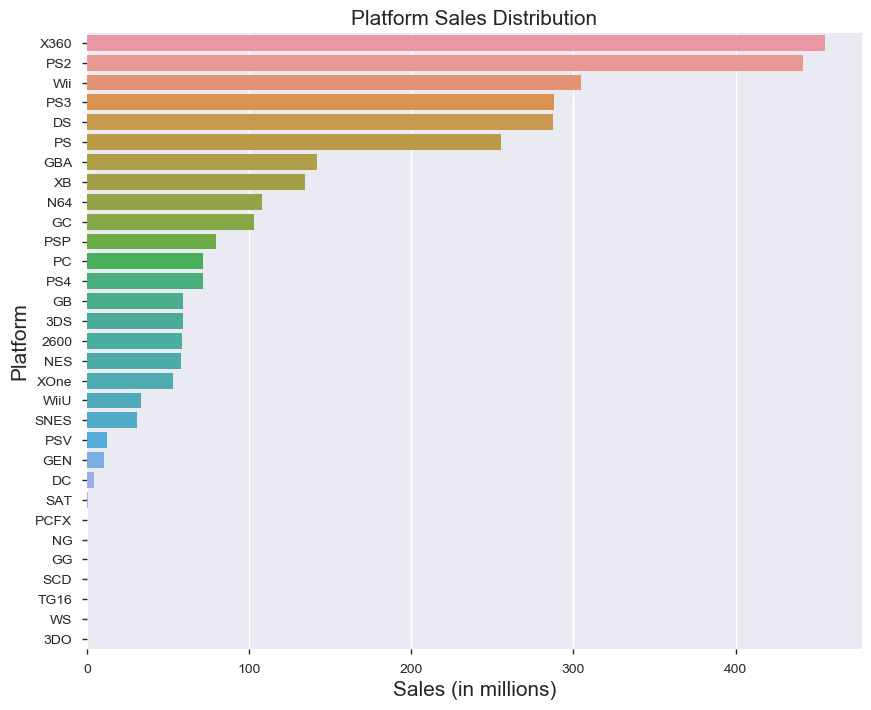

In [158]:
# Create grouped dataframe for platform sales
platform_df = pd.DataFrame(train.groupby('Platform').NA_Sales.sum().sort_values(ascending=False), columns=['NA_Sales'])

# Create figure size
plt.figure(figsize=(10,8))

# Create bar plot
sns.barplot(x='NA_Sales',
            y=platform_df.index,
            data=platform_df)

# Set plot features
plt.xlabel('Sales (in millions)', fontsize=15)
plt.ylabel('Platform', fontsize=15)
plt.title('Platform Sales Distribution', fontsize=15)
plt.show()

Surprised that PS4 is one of newer systems that is not within the top 10. PS4's predecessors performed better in North America. This makes me wonder how will the new PS5 will perform when it's released in 2020/2021. There's going to be an abundant amount of upgrades hopefully after 7/8 years.

### Year feature

How's the sales distribution look like by year? Remember that there is approximately 1.61% (201) of null values in this column.

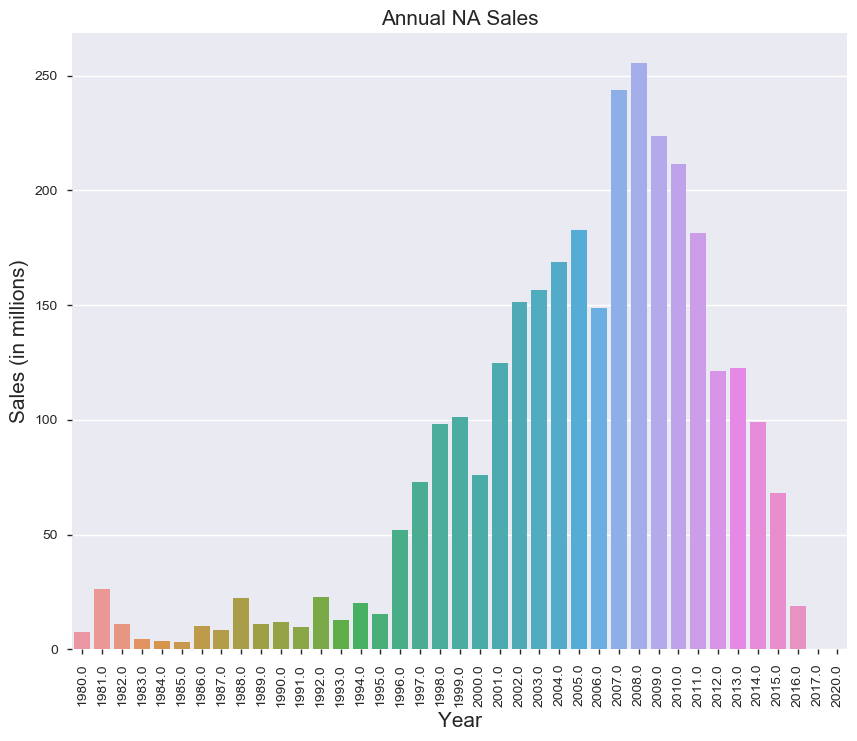

In [159]:
# Create grouped dataframe for yearly sales
year_df = pd.DataFrame(train.groupby('Year', as_index=False).NA_Sales.sum().sort_values(by='Year', ascending=True))

# Create figure space
plt.figure(figsize=(10,8))

# Create boxplots
sns.barplot(y='NA_Sales',
            x='Year',
            data=year_df)

# Set plot features
plt.xticks(rotation='90')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Sales (in millions)', fontsize=15)
plt.title('Annual NA Sales', fontsize=15)
plt.show()

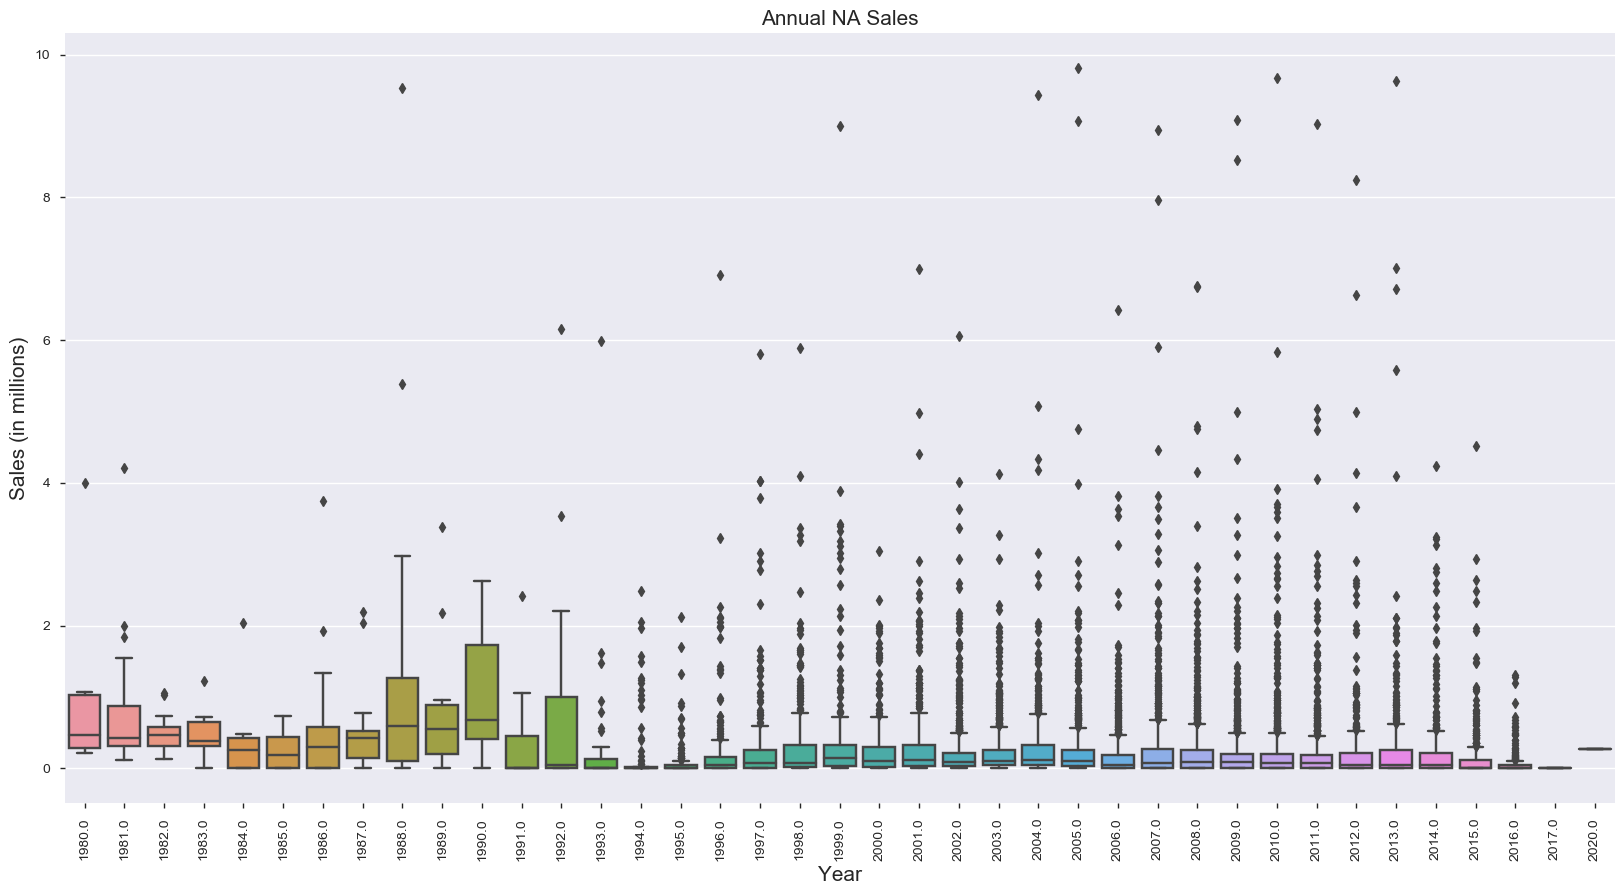

In [160]:
# Create figure space
plt.figure(figsize=(20,10))

# Create boxplots
sns.boxplot(y='NA_Sales',
            x='Year',
            data=train)

# Set plot features
plt.xticks(rotation='90')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Sales (in millions)', fontsize=15)
plt.title('Annual NA Sales', fontsize=15)
plt.show()

Mean sales are a lot higher from 1980 - 1990. Now that's interesting. Maybe games were much more popular in the past as it was new and innovative vs. the age of technology where games are everywhere now. Within that same timeframe, the distribution was a lot tighter as well vs. 1993 and onward. I remember when I first got the Super Nintendo system. I was super excited as my parents brought it home one night. Those were the days...

Now I am wondering does the data contain the street fighter game? Let's check.

### Street fighter!

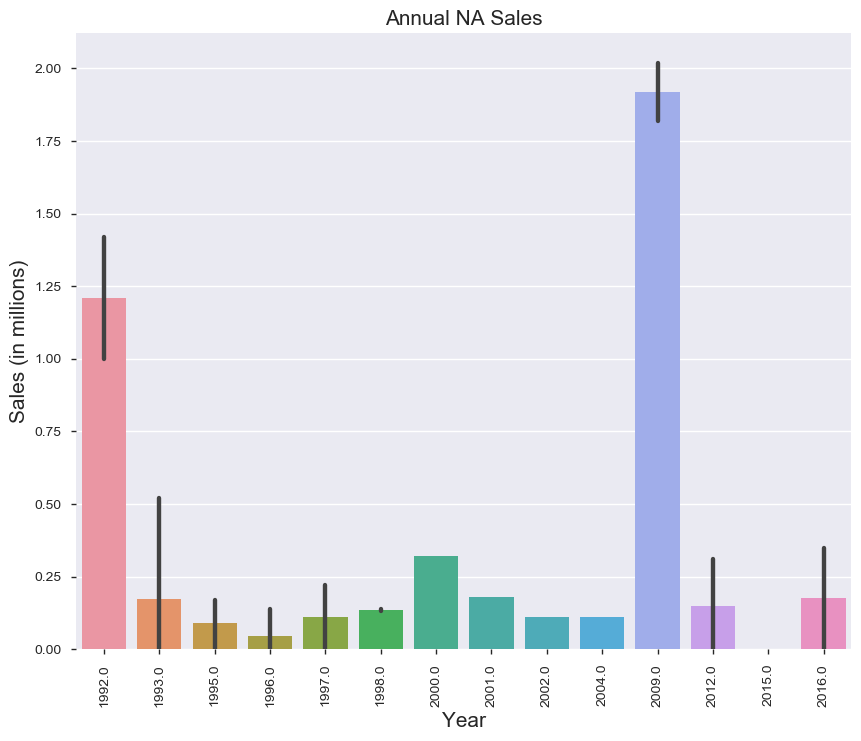

In [161]:
# Slice the dataset and index using the Name
street_fighter_df = train[train['Name'].str.contains('Street Fighter')].sort_values(by='Year', ascending=False).dropna()

# Create figure space
plt.figure(figsize=(10,8))

# Create boxplots
sns.barplot(y='NA_Sales',
            x='Year',
            data=street_fighter_df)

# Set plot features
plt.xticks(rotation='90')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Sales (in millions)', fontsize=15)
plt.title('Annual NA Sales', fontsize=15)
plt.show()

Nice! Looks like the dataset does capture one of the most popular Street Fighter games when it was released back in the early 90s. Definitely one of the games I remember playing the most. 

__What was in 2009?__ 

After a quick Google search: "Street Fighter IV is a 2008 fighting game published by Capcom, who also co-developed the game with Dimps. It was the first original main entry in the series since Street Fighter III in 1997, a hiatus of eleven years." Well, correlated or not?

In [162]:
# Show the data
street_fighter_df

,index,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Log_NA_Sales
6304,2511,2513,Street Fighter V,PS4,2016.0,Fighting,Capcom,0.35,0.26,0.08,0.13,0.82,0.300105
8191,13044,13046,Street Fighter V,PC,2016.0,Fighting,Capcom,0.00,0.05,0.00,0.00,0.05,0.000000
10051,10726,10728,Ultra Street Fighter IV,PS4,2015.0,Fighting,Capcom,0.00,0.08,0.00,0.01,0.10,0.000000
1388,15044,15047,Street Fighter X Tekken,PC,2012.0,Fighting,Capcom,0.00,0.02,0.00,0.00,0.02,0.000000
7883,6834,6836,Street Fighter X Tekken,PSV,2012.0,Fighting,Capcom,0.14,0.05,0.01,0.04,0.24,0.131028
106,4155,4157,Street Fighter X Tekken,X360,2012.0,Fighting,Capcom,0.31,0.10,0.03,0.03,0.47,0.270027
1653,274,275,Street Fighter IV,PS3,2009.0,Fighting,Capcom,2.02,1.06,0.58,0.53,4.19,1.105257
10815,483,484,Street Fighter IV,X360,2009.0,Fighting,Capcom,1.82,0.71,0.15,0.26,2.95,1.036737
10349,8828,8830,Street Fighter Anniversary Collection,XB,2004.0,Fighting,Capcom,0.11,0.03,0.00,0.01,0.15,0.104360
1054,8902,8904,Street Fighter Alpha 3,GBA,2002.0,Fighting,Capcom,0.11,0.04,0.00,0.00,0.15,0.104360


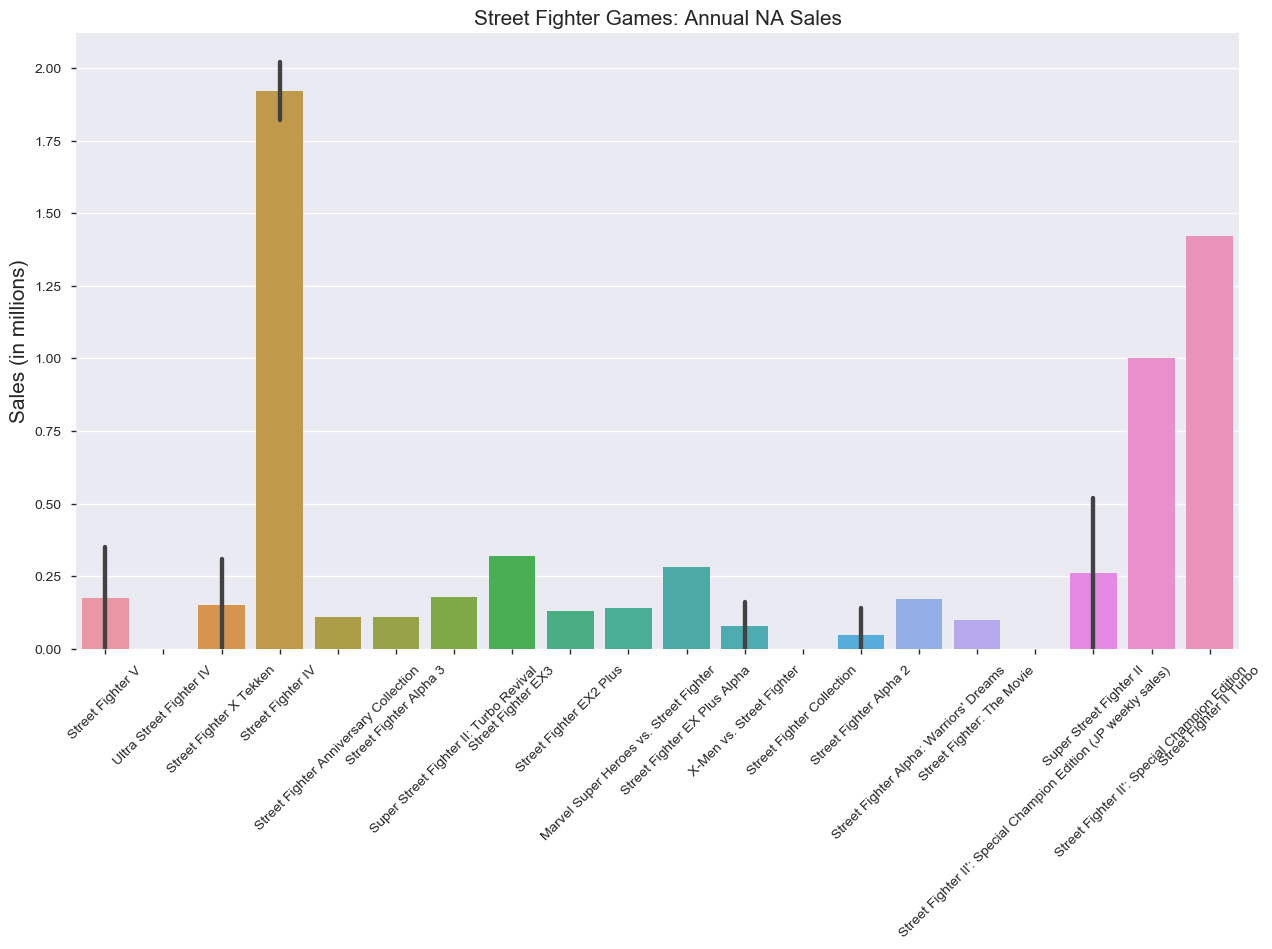

In [163]:
# Create figure space
plt.figure(figsize=(15,8))

# Create boxplots
sns.barplot(y='NA_Sales',
            x='Name',
            data=street_fighter_df)

# Set plot features
plt.xticks(rotation='45')
plt.xlabel('', fontsize=15)
plt.ylabel('Sales (in millions)', fontsize=15)
plt.title('Street Fighter Games: Annual NA Sales', fontsize=15)
plt.show()

Street Fighter 2 versions are definitely a favorite minus the Tekken version.

### Sales by Platform

In [164]:
sales_by_platform = train.groupby(['Year','Platform']).sum()[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']]
sales_by_platform

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
Year   Platform                                                         
1980.0 2600          7.31      0.46      0.00         0.08          7.85
1981.0 2600         26.11      1.53      0.00         0.24         27.95
1982.0 2600         10.85      0.65      0.00         0.12         11.61
1983.0 2600          4.32      0.27      0.00         0.05          4.64
       NES           0.34      0.07      2.83         0.01          3.25
1984.0 2600          0.26      0.01      0.00         0.00          0.27
       NES           3.39      0.83      9.60         0.14         13.96
1985.0 2600          0.42      0.03      0.00         0.00          0.45
       NES           2.59      0.72      6.31         0.08          9.70
       PC            0.00      0.03      0.00         0.01          0.03
1986.0 2600          0.63      0.04      0.00         0.00          0.66
       NES           9.47      2.05     16.08         1.83         29.43
1987.0 2600          1.77      0.09      0.00         0.01          1.90
       NES           6.62      1.32     11.63         0.19         19.76
1988.0 2600          0.69      0.04      0.00         0.01          0.75
       GB            0.82      0.23      0.35         0.03          1.43
       NES          20.79      5.92     14.14         0.84         41.69
       PC            0.00      0.02      0.00         0.01          0.03
1989.0 2600          0.59      0.03      0.00         0.01          0.62
       GB            5.78      2.63      6.48         0.40         15.30
       NES           4.75      0.81      2.20         0.09          7.85
1990.0 GB            2.24      0.89      1.00         0.43          4.56
       GEN           1.86      0.55      0.11         0.08          2.60
       NES           5.40      1.45      6.10         0.19         13.15
       SNES          2.50      0.85      2.06         0.12          5.55
1991.0 GB            1.43      0.68      2.65         0.08          4.84
       NES           2.83      0.52      2.00         0.16          5.51
       SNES          5.47      1.84      7.82         0.37         15.49
1992.0 GB           10.39      3.63      5.81         0.53         20.35
       GEN           4.70      1.18      0.43         0.18          6.50
       GG            0.00      0.00      0.04         0.00          0.04
       NES           0.84      0.14      0.97         0.03          1.98
       PC            1.22      1.61      0.00         0.10          2.93
       SNES          5.62      1.92     14.30         0.31         22.14
1993.0 GEN           0.00      0.00      0.60         0.00          0.60
       NES           1.32      0.31      0.96         0.04          2.63
       NG            0.00      0.00      0.14         0.00          0.14
       SNES         11.50      3.65     15.32         0.74         31.20
1994.0 3DO           0.00      0.00      0.02         0.00          0.02
       GB            6.03      2.36      3.19         0.60         12.17
       GEN           4.18      1.41      0.79         0.27          6.63
       NG            0.00      0.00      0.45         0.00          0.45
       PC            4.66      5.77      0.00         0.35         10.77
       PS            1.39      0.95      1.80         0.30          4.45
       SAT           0.17      0.12      2.42         0.02          2.72
       SCD           0.00      0.00      0.30         0.00          0.31
       SNES          3.88      0.80     16.01         0.15         20.83
1995.0 3DO           0.00      0.00      0.08         0.00          0.08
       GB            0.69      0.14      2.40         0.05          3.28
       NG            0.00      0.00      0.30         0.00          0.30
       PC            1.71      2.27      0.00         0.23          4.23
       PS           11.05      6.48      6.62         1.37         25.46
       SAT           0.55      0.42      8.51         0.05          9.54
  

There's a lot of information from this table. Let's summarize it.

In [165]:
sales_by_platform.describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,232.000000,232.000000,232.000000,232.000000,232.000000
mean,13.277888,7.476293,3.970819,2.491767,27.231121
std,18.360072,10.900361,5.417533,4.504291,35.586996
min,0.000000,0.000000,0.000000,0.000000,0.020000
25%,0.727500,0.305000,0.047500,0.060000,2.750000
50%,4.875000,2.865000,1.765000,0.470000,11.600000
75%,18.615000,9.045000,5.927500,2.555000,36.265000
max,79.040000,50.590000,28.290000,35.350000,171.630000


### Numeric & Categorical Features

In [166]:
# Find numeric features
num_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_data = train.select_dtypes(include=num_dtypes)
num_data = num_data.drop(['index', 'Rank'], axis=1)

# Find all other features
col_data = train.select_dtypes(include=['object'])

Let's plot the numerical features now and see if there are multicollinearity within the dataset. Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent (causing bias if left alone). If the degree of correlation between the variables is high enough, it can cause problems when you fit a model and interpret the results (skew).

We can take a look at a correlation plot to identify variables that fit this category or check if the variance inflation factor (VIF) > 10 (highly correlated).

How do we choose between which variable should we keep if they are correlated? We can apply some statistical tests to see which variable may be more beneficial
for the dependent variable. Some tests involve one-way t-tests (2 independent variables) and ANOVA (multiple variables), choosing the one with the highest R^2 value or a simple regression and check the values after.

Another way is to do some form of dimensionality reduction. Principal component analysis is a popular method to reduce dimensionality when there are a lot of features.

One way I have not tested yet is to combine both variables to create a new super variable that be beneficial for the model. Beware that combining may have same results.

Now let's do some correlation analysis and see if there is multicollinearity involved.


### Correlation to Log_NA_Sales

In [167]:
# Correlation to Log NA Sales feature
pd.DataFrame(abs(num_data.corr()['Log_NA_Sales']).sort_values(ascending=False))

,Log_NA_Sales
Log_NA_Sales,1.000000
NA_Sales,0.929583
Global_Sales,0.838971
EU_Sales,0.689125
Other_Sales,0.532873
JP_Sales,0.279846
Year,0.115488


The 'Year' feature doesn't look very correlated to sales, which is an interesting find. I wonder if we can predict NA sales based on EU, JP, and Other sales. We can't use the 'Global_Sales' feature in our model since it inherits the NA Values already (example of data leakage - which uses a feature that is already calculated into the feature we are predicting).

### Correlation Map

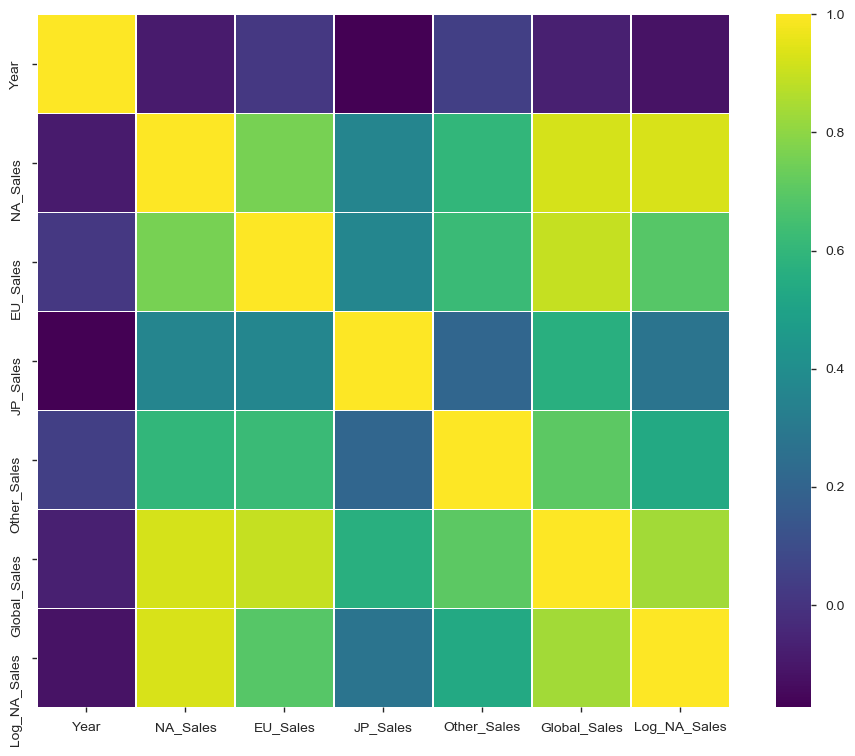

In [168]:
# Create a figure space
plt.subplots(figsize=(12,9))

# Create matrix
corr_plot = sns.heatmap(num_data.corr(),
#                         annot=True,
                          cmap='viridis', # YlGnBu, RdBu_r
                          linewidths=0.20,
                          linecolor='white',
                          vmax=1,
                          square=True,
                          fmt='.1g',
                          annot_kws={"size": 12})
corr_plot
plt.show()

- In statistics, the correlation coefficient r measures the strength and direction of a linear relationship. don't get this mixed upwith coefficient of determination which is the r^2 which shows percentage of variation in y which is explained by the x variables.
    - when Pearson's r is close to 1 that means there is a strong relationship between the two variables
    - when Pearson's r is close to 0 that means there is a weak relationship between the two variables

### Coefficient of Determination (R-Squared)

The coefficient of determination provides a 'goodness of fit' measure for the predictions to the observations. This is a value between 0 and 1. It's the proportion of the variance in the dependent variable (y) that is predictable from the independent variable (x).

With just the features we have, there isn't a lot of features that are highly correlated. The highest would be 'EU_Sales' since we would not use either 'NA_Sales' or 'Global_Sales' in our model.

In [169]:
# Top numeric features
r_squared = num_data.corr()**2
pd.DataFrame(r_squared.Log_NA_Sales.sort_values(ascending=False))

,Log_NA_Sales
Log_NA_Sales,1.000000
NA_Sales,0.864124
Global_Sales,0.703873
EU_Sales,0.474894
Other_Sales,0.283953
JP_Sales,0.078314
Year,0.013337


### Pandas profiling

This is very handy. In a single line of code, it displays the data profiling report. Some of the information is pretty detailed. Check it out below. Beware, it does get pretty long.

In [170]:
pandas_profiling.ProfileReport(train)

Number of variables,14
Number of observations,12438
Total Missing (%),0.1%
Total size in memory,1.3 MiB
Average record size in memory,112.0 B
Numeric,7
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,3


## Feature engineering

We want to use the Publisher feature in our model but the data is extremely sparse when we create dummy variables and there are many publishers who have only a few games so let's group them together by size.

In [171]:
train.head()

,index,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Log_NA_Sales
0,6149,6151,Need for Speed: Most Wanted,WiiU,2013.0,Racing,Electronic Arts,0.14,0.12,0.00,0.02,0.28,0.131028
1,12967,12969,Taito Legends Power Up,PSP,2007.0,Action,Destineer,0.05,0.00,0.00,0.00,0.05,0.048790
2,8523,8525,Magic: The Gathering - Battlegrounds,XB,2003.0,Strategy,Atari,0.12,0.03,0.00,0.01,0.16,0.113329
3,2946,2948,Shrek the Third,X360,2007.0,Action,Activision,0.54,0.10,0.00,0.06,0.69,0.431782
4,16077,16080,Destiny Links,DS,2009.0,Role-Playing,Namco Bandai Games,0.00,0.00,0.01,0.00,0.01,0.000000


In [172]:
# Identify the publishers
publisher_df = pd.DataFrame(train.Publisher.value_counts().sort_values(ascending=False)).reset_index()
publisher_df.columns = ['Publisher', 'Data Count']
publisher_df.head()

# Join
train = pd.merge(train, publisher_df, on='Publisher', how='left')
test = pd.merge(test, publisher_df, on='Publisher', how='left')

# Define a function to group
def create_publisher_group(var):
    text=''
    if var>100:
        text='Large'
    elif var>50:
        text='Mid'
    else:
        text='Small'
    return text


In [173]:
# Use function to create a new feature
train['Publisher_Group'] = train['Data Count'].map(create_publisher_group)
test['Publisher_Group'] = test['Data Count'].map(create_publisher_group)

### Group Years

In [174]:
# Identify the years
years_df = pd.DataFrame(train.Year.value_counts().sort_values(ascending=False)).reset_index()
years_df.columns = ['Year', 'YearCount']
years_df.head()

# Join
train = pd.merge(train, years_df, on='Year', how='left')
test = pd.merge(test, years_df, on='Year', how='left')

# Define a function to group
def create_year_group(var):
    text=''
    if var>=1980 and var<1990:
        text='1980s'
    elif var>=1990 and var<2000:
        text='1990s'
    elif var>=2000 and var<2000:
        text='2000s'
    else:
        text='2010s'
    return text

In [175]:
# Use function to create a new feature
train['Year_Group'] = train['YearCount'].map(create_year_group)
test['Year_Group'] = test['YearCount'].map(create_year_group)

### Cleaning up nulls

In [176]:
model_data = train.dropna(axis=0)
model_data.reset_index(drop=True, inplace=True)
model_data.shape

(12208, 17)

### Check Skew


In [177]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Loop through data types
numeric_list = []
for i in model_data.columns:
    if model_data[i].dtype in numeric_dtypes:
        numeric_list.append(i)

# Use apply() to check skew on every feature
skew_features = model_data[numeric_list].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'Skews': skew_features})
skews

,Skews
Other_Sales,26.074486
JP_Sales,9.684103
EU_Sales,9.331214
Global_Sales,8.241376
NA_Sales,7.072897
Log_NA_Sales,3.024219
Data Count,0.411322
Rank,-0.010834
index,-0.010901
YearCount,-0.250600


Let's do a transformation on the features that are over 0.50 (mid).

### Which transformation should we use on the features?

My go-to transformation is normally a boxcox transformation, but it does not handle zero values like 'Year'. There is another transformation that's [boxcox1p](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html). All it really does is add a 1 to the value so no values would be zero, which is what we did earlier to do a log transformation for NA_Sales.

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. This helps with any outliers and helps us meet the normality assumption for many statistical techniques.

At the core of the transformation is an exponent (lambda), which varies from -5 to 5. All values of lambda are considered and the optimal value for your data is selected. To determine what is "best", it looks for the best approximation of a normal distribution curve.

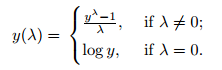

In [178]:
Image.open('..\\Images\\10-boxcox.png')

### Create a function to plot histogram and probability plot (hist_qq_plot())

In [179]:
# Define the function
def hist_qq_plot(var):
    # Get normal distribution 
    sns.distplot(var, fit=norm)
    fig = plt.figure()
    qq = stats.probplot(var, plot=plt,)

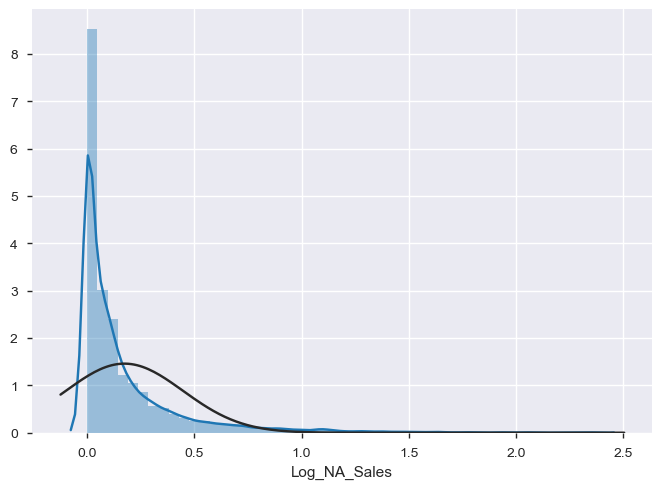

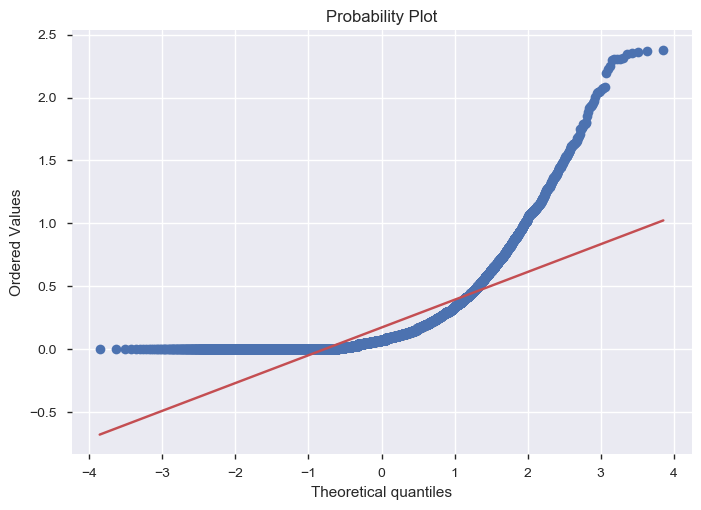

In [180]:
hist_qq_plot(model_data.Log_NA_Sales)

### Transformation of the features

We have our high skewed features so let's make a transformation on them. But first, let's dissect the idea of feature transformation in statistics and machine learning.

__Statistics (To Explain)__
When we attempt to transform our features we are also changing the correlation coefficients as well. Our attempt to make the data as "gaussian" as possible is the result of this. If we are transforming the train data then we also have to transform the test data as we wouldn't be able to explain the changes if the data is completely different. For example, if we log our features for a linear regression then the entire equation changes, which will hopefully give a higher R-squared value. Because of this, we've found a different a better equation to "fit" the data with. By transforming the data, the model has changed, and therefore there explanation changes as well.

__Machine Learning (To Predict)__
In ML, our end goal is accurately predict our unknown values based on a given dataset. Yes, we want to be able to explain why our results may be good or may be bad but as long as our model returns the correct predicted value then it is considered useful already. Feature transformation is part of the framework for constructing models that generate accurate predictions for future, yet-to-be-seen data. 

My go-to transformation is normally a boxcox transformation, but it does not handle zero values. There is another transformation that's [boxcox1p](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html). All it really does is add a 1 to the value so no values would be zero, which is what we did earlier to do a log transformtion for NA_Sales.

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. This helps with any outliers and helps us meet the normality assumption for many statistical techniques. Remember that the test only works for positive data

In [181]:
# Get high skews
high_skew = skew_features[skew_features>0.50]
skew_index = high_skew.index
print('There are {} skewed features.'.format(high_skew.shape[0]))

# Loop through the index and transform
for i in skew_index:
    model_data[i] = boxcox1p(model_data[i], boxcox_normmax(model_data[i]+1))

# Get new transformed variables
new_skew_features = model_data[numeric_list].apply(lambda x: skew(x)).sort_values(ascending=False)
new_skews_df = pd.DataFrame({'Skew': new_skew_features})
new_skews_df

There are 6 skewed features.


,Skew
JP_Sales,0.982373
Other_Sales,0.479477
Data Count,0.411322
EU_Sales,0.405574
Log_NA_Sales,0.405179
NA_Sales,0.395108
Global_Sales,0.210302
Rank,-0.010834
index,-0.010901
YearCount,-0.250600


## Modeling

So now we have some visual analyses done and cleaned up the data. We will move onto the modeling stage. This includes making sure we have our train and test dataset split up all the way to comparing tuned models. Some steps are listed below:

Modeling & Scoring
- Splitting the data into train and test sets
    - Always make sure you have a completely separate data set to test your final model on after hyperparameter tuning and training has been done
    - Standardizing the data to be on similar scales
    - Create baseline & pre-tuned models
    - Cross-validate the models
    - Hyperparameter tuning
    - Create cross-validated tuned models using best hyperparameters
    - Compare models (Pre-Tuned vs. CV vs. Tuned vs. CV Tuned)
    
We will start off with a basic algorithm, which is easy to implement and wil be used as a baseline model.

### Dropping features that we are not using

Remove any features that may cause multicollinearity before we split our data. This includes 'Global_Sales' and 'NA_Sales'.

In [182]:
test.head()

,index,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Log_NA_Sales,Data Count,Publisher_Group,YearCount,Year_Group
0,3807,3809,Oni,PS2,2001.0,Action,Take-Two Interactive,0.26,0.20,0.00,0.07,0.53,0.231112,314.0,Large,360.0,2010s
1,9658,9660,Monster Truck Madness,GBA,2003.0,Racing,THQ,0.09,0.03,0.00,0.00,0.12,0.086178,530.0,Large,614.0,2010s
2,2221,2223,Buzz! Quiz World,PS3,2009.0,Misc,Sony Computer Entertainment,0.16,0.58,0.00,0.20,0.93,0.148420,510.0,Large,1060.0,2010s
3,8138,8140,Doom (2016),PC,2016.0,Shooter,Bethesda Softworks,0.06,0.10,0.00,0.01,0.18,0.058269,48.0,Small,257.0,2010s
4,44,45,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.98,1.568616,314.0,Large,428.0,2010s


In [183]:
# Drop
model_data.drop(['Global_Sales', 'NA_Sales', 'Rank', 'index', 'Name', 'Publisher', 'Data Count', 'YearCount', 'Year'], axis=1, inplace=True)
test.drop(['Publisher', 'Data Count', 'YearCount', 'Year', 'index', 'Rank', 'Name', 'NA_Sales', 'Global_Sales'], axis=1, inplace=True)

In [184]:
# Get data shape, info, columns, & dimensions
print ("*"*44)
print('********** train shape: ' + str(model_data.shape) + '*'*10)
print ("*"*42)
print('********** test shape: ' + str(test.shape) + '*'*10)

********************************************
********** train shape: (12208, 8)**********
******************************************
********** test shape: (4150, 8)**********


In [185]:
# Dev purposes
dupe_train = model_data.copy()
dupe_test = test.copy()

In [186]:
test.head()

,Platform,Genre,EU_Sales,JP_Sales,Other_Sales,Log_NA_Sales,Publisher_Group,Year_Group
0,PS2,Action,0.20,0.00,0.07,0.231112,Large,2010s
1,GBA,Racing,0.03,0.00,0.00,0.086178,Large,2010s
2,PS3,Misc,0.58,0.00,0.20,0.148420,Large,2010s
3,PC,Shooter,0.10,0.00,0.01,0.058269,Small,2010s
4,PS4,Action,5.81,0.36,2.02,1.568616,Large,2010s


In [187]:
model_data.head()

,Platform,Genre,EU_Sales,JP_Sales,Other_Sales,Log_NA_Sales,Publisher_Group,Year_Group
0,WiiU,Racing,0.054035,0.000000,0.014316,0.090061,Large,2010s
1,PSP,Action,0.000000,0.000000,0.000000,0.042027,Small,2010s
2,XB,Strategy,0.023810,0.000000,0.008412,0.081569,Large,2010s
3,X360,Action,0.050333,0.000000,0.024978,0.159016,Large,2010s
4,DS,Role-Playing,0.000000,0.008873,0.000000,0.000000,Large,2010s


### Dummy variables

Dummy variables is an important pre-modeling step. It's usually used when important features are not numerical so we have to transform them into binary values 0 or 1. Many models would prefer or need numerical features to be used in order for it to work properly. While working with a dataset, we want to make sure the computer is able to understand the differences. Computer processing power is also a lot better with numbers, vectors, or anything numeric related vs. strings/text/categorical values.

To transform variables, we must use pd.get_dummies() function. This will produce sparse columns which will grow horizontally and can get exponentially more difficult as we have to search through more dimensions.

__Note:__ I am going to rename my variables multiple times to make sure I don't have to go back if I make a mistake. If this was a large dataset then I would change my methods as we want to always think of memory usage while developing our models.

In [188]:
# Create a column for test and train
dupe_train['Data'] = 'Train'
dupe_test['Data'] = 'Test'

In [189]:
# dupe_train['Year'] = dupe_train['Year'].astype(str)
# dupe_test['Year'] = dupe_test['Year'].astype(str)

In [190]:
# Create a list of features for specific dummy variables if needed
dummy_list = ['Platform', 'Genre', 'Publisher_Group', 'Year_Group']

# Now I need to get my dummy list for my train set
# combined = pd.concat([dupe_train, dupe_test], axis=0)
dummy_train = pd.get_dummies(dupe_train, columns=dummy_list).reset_index(drop=True)
dummy_test = pd.get_dummies(dupe_test, columns=dummy_list).reset_index(drop=True)

In [191]:
# Check
print(dummy_train.shape)
print(dummy_test.shape)

(12208, 52)
(4150, 49)


Now that I got my full dataset for my training, I have to get the same features as well for my test set. It looks like we have 3 features that have been under encoded in the test set so now we have to add it in. Reminder that we couldn't combine the sets and then create the dummy sets since that will introduce data leakage. (Surprisingly I have see a lot of preprocessing that included that specific step.)

In [192]:
def add_missing_dummy_columns(test_df, train_df):
    '''
    Function to check for missing column names
    Loops through missing columns and adds it to the data passed with zero
    '''
    missing_cols = set(train_df)-set(test_df)
    for c in missing_cols:
        test_df[c]=0

In [193]:
def remove_extra_columns_and_reorder(test_df, train_df):
    '''
    Function that will remove any extra columns that's not in train_df
    Reorder columns in the same order as train_df
    '''
    extra_cols = set(test_df)-set(train_df)
    test_df.drop(extra_cols, axis=1, inplace=True)

In [194]:
# Check difference
set(dummy_train) - set(dummy_test)

{'Platform_3DO', 'Platform_GG', 'Platform_PCFX'}

In [195]:
# Add missing columns to test set
add_missing_dummy_columns(dummy_test, dummy_train)

In [196]:
# Remove any extra columns if any
remove_extra_columns_and_reorder(dummy_test, dummy_train)

In [197]:
# Reorder
dummy_train = dummy_train.reindex(sorted(dummy_train.columns), axis=1)
dummy_test = dummy_test.reindex(sorted(dummy_test.columns), axis=1)

In [198]:
dummy_train.head(1)

,Data,EU_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Publisher_Group_Large,Publisher_Group_Mid,Publisher_Group_Small,Year_Group_2010s
0,Train,0.054035,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [199]:
dummy_test.head(1)

,Data,EU_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Publisher_Group_Large,Publisher_Group_Mid,Publisher_Group_Small,Year_Group_2010s
0,Test,0.2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [200]:
# Drop Data
dummy_train.drop(['Data'], axis=1, inplace=True)
dummy_test.drop(['Data'], axis=1, inplace=True)

# Check
print(dummy_train.shape)
print(dummy_test.shape)
dummy_train.head(1)

(12208, 51)
(4150, 51)


,EU_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,...,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Publisher_Group_Large,Publisher_Group_Mid,Publisher_Group_Small,Year_Group_2010s
0,0.054035,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1


### Split the variables between X and y

In [201]:
# Split training
y = dummy_train['Log_NA_Sales']
X = dummy_train.drop(['Log_NA_Sales'], axis=1)

In [202]:
# Evaluation
from sklearn.metrics import mean_squared_error #RMSE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [203]:
# Import train_test_split function
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

# This data has already been split between train and test since we have the y feature
X_train = X
y_train = y

# Test
y_test = dummy_test['Log_NA_Sales']
X_test = dummy_test.drop(['Log_NA_Sales'], axis=1)

# Check
print(X_train.shape)
print(X_test.shape)

(12208, 50)
(4150, 50)


### Models

In [204]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, plot_importance 

### But wait the data isn't linear...

The data is not normally distributed so therefore I need to scale my data.

### What is feature scaling?

Many machine learning algorithms work better when features are on a relatively same scale and normally distributed. There are a few scalers we can use such as: MinMaxScaler, RobustScaler, and StandardScaler. These are all scikit-learn methods to preprocess data for machine learning.

To break it down, __scaling__ just means that we are converting the range of our values so our features can be comparable if there is a change.

__Standardize__ (Z-score normalization) means that we are changing the values so that the distribution standard deviation from the mean is zero. To standardize you would need to subtract mean and divide by standard deviation of the feature.
- Use when transformation needs to be close to a normal distribution
- If data is not normally distributed, this is not the best scaler to use

__Normalizing__ can mean a few things like standardizing or scaling so it's a little confusing at first. Normalization of data implies to normalize residuals using the methods of transformation.

For me, normalization could mean scaling using __MinMaxScaler__ method, which basically shrinks the range of the data so it is fixed from 0 to 1. For this scaling method to work you would need to subtract the min value of your feature and then divide by the difference of the max value and the min value. This method is still sensitive to outliers.
- Use when the upper and lower bounds of the features are well known or when distribution is not Guassian, responds well if standard deviation is small
- This scaler works better for cases in which the standard scaler might not work so well. If the distribution is not Gaussian or the standard deviation is very small, the min-max scaler works better
- It is sensitive to outliers, so if there are outliers in the data, you might want to consider the Robust Scaler

__RobustScaler__ transforms each feature vector by subtracting the median and then dividing by the IQR (replace min with Q1 and Max with Q3). This method does not scale the data into a predetermined interval like MinMaxScaler. 
- Use RobustScaler if you want to reduce the effects of outliers, unlike MinMaxScaler
- This means it is using the less of the data for scaling so it’s more suitable for when there are outliers in the data

**Summary**
- **MinMaxScaler** - Scales the data using the max and min values so that it fits between 0 and 1
- **StandardScaler** - Scales the data so that it has mean 0 and variance of 1
- **RobustScaler** - Scales the data similary to Standard Scaler, but makes use of the median and scales using the interquertile range so as to aviod issues with large outliers

Call the MinMaxScaler() function
1. Use fit_transform() to scale the data
2. Use transform() on all other datasets that will be used

__Additional Resources__
- [Feature Scaling in Scikit-learn](http://benalexkeen.com/feature-scaling-with-scikit-learn/)
- [Scikit-learn preprocessing documentation](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)
- [Scikit-learn scaling documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py.)

Let's scale our data using MinMaxScaler() since our data is not really normal as seen from the distribution early on.

In [205]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Transform the variables to be on the same scale as the train data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling process

__Initial modeling steps__
1. Fit the model
2. Predict using the test set
3. Estimate the error

__Cross-validation modeling steps__
1. Fit the model
2. Cross-validate with training data
3. Estimate the mean error

__Hyperparameter tuning cross-validation modeling steps__
1. Fit the model with grid search or random search of hyperparameters
2. Cross-validate with training data
3. Estimate the mean error
4. If error is acceptable, fit new cv-tuned model with training data else re-tune
5. Predict using the test set
6. Estimate the error

Before we begin let's go over some cross-validation notes.

### What is cross-validation?

The idea of cross-validation is simply a procedure used to evaluate machine learning models where data is limited and resampled to best test our evaluation metric then averaged to get an overall score. 

__k-Fold Cross-Validation__

A popular cv method would be k-fold cv where the dataset is split in k number of partitions (folds). If the dataset has 100 observations and k = 10 then there would be 10 folds each having 10 observations. Out of the 10 folds, 1 of them will be considered a test set and the rest training. Once that first split has been trained and tested it will go on to the next random split of training and evaluation. After the end of the 10 splits, the result is averaged.

The general step by step procedure is as follows from [MLM](https://machinelearningmastery.com/k-fold-cross-validation/):
1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    1. Take the group as a hold out or test data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the test set
    4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

Some types of methods in sklearn.model_selection: KFold, StratifiedShuffleSplit, StratifiedKFold or ShuffleSplit

Here's an image below of how a 5-fold cross-validation would look like.

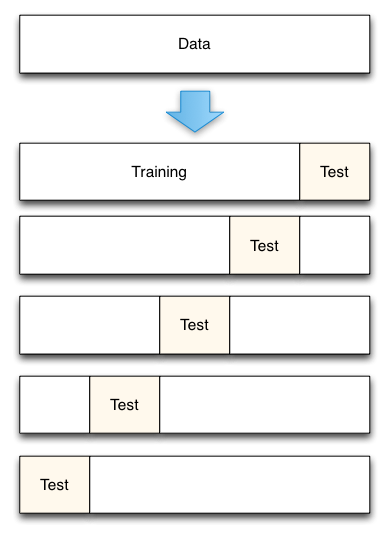

In [206]:
Image.open('..\\Images\\10-cv.png')

Generally we would want to fit our algorithm and then predict using the predict() function. For our CV step, we add a step in between the fit and predict with cross_val_score() where it would cross-validate our training data. So let's create our first model and then cross-validate it.

In [207]:
# Create a function that will calculate error
def base_rmse(y, y_pred):
    '''
    Return the sqrt of the mean squared error between the observed and predicted values
    '''
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse
    
# Create a function that will calculate cross-validated mean error
def cv_rmse(model, X=X_train_scaled, y=y_train):
    '''
    Return the sqrt of the mean cross-validated mean squared error between the observed and predicted values
    Replace the default parameter arguments X & y when test data is used instead of training
    '''
    cv_rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv))
    return cv_rmse

In [208]:
# Set cross-validate method
cv = KFold(n_splits=10, shuffle=True, random_state=100)

Now that we have our algorithms loaded, train and test data split, chosen our cross-validation method, and scoring method, we can create some models and see how well it performs. We will not be changing any hyperparameters initially to get an idea of our scores.

Here are the steps as a reminder:
1. Import algorithms
2. Set any methods we might need
3. Fit the model (with or without cv)
4. Predict on test set
5. Evaluate & Score

Let's start off with the most basic algorithm, linear regression.

### What is a linear regression?

A linear regression is type of model that looks at the relationship between a dependent variable and one or more independent variable(s). It's a model that predicts the target as a weighted sum of the feature inputs. The overall idea on how it's used is to see help answer the question: do the predictor variables do a good job in predicting the outcome? The simplest form of the linear equation is shown below. Our dependent variable (Log_NA_Sales) is being predicted by the linear component (Genre + Genre coefficient + constant) and an error component (random, could not be modeled).

Assumptions for the regression to work
- Linear: Needs a linear relationship between the dependent and independent variables; linearity leads to interpretable models and unfortunately this dataset is not normal
    - Check by plotting X to y
- Normality of Residuals: Requires error term to be normally distributed
    - Check by qq-plot
- Homoscedasticity: Assumes that residuals are approximately equal for all predicted dependent variable values (variance of residual is the same for any value of X)
    - Check by plotting fitted values & residuals
- Multicollinearity: Variance Inflation Factor (VIF) – independent variables must not be highly correlated with each other
    - Check by correlation matrix or statistical tests
- Independence: Observations are independent of each other
    - Check by correlation matrix

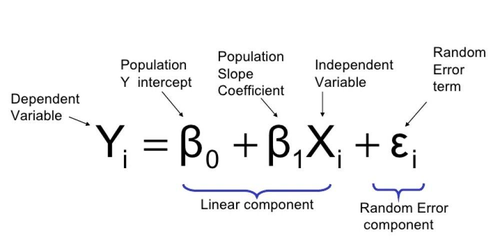

In [248]:
# Resizing and maintain aspect ratio
basewidth = 500
img = Image.open('..\\Images\\10-linear-regression.jpg')
wpercent = (basewidth/float(img.size[0]))

# Get height
hsize = int((float(img.size[1])*float(wpercent)))

# Resize
img = img.resize((basewidth,hsize), Image.ANTIALIAS)

# Show pic
img

In [210]:
def lm_procedure(model=LinearRegression()):
    model.fit(X_train_scaled, y_train)

    # To retrieve the intercept:
    print(model.intercept_)

    # For retrieving the slope:
    print(model.coef_)

    # Predict
    y_pred = model.predict(X_test)

    # Change to 1D
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    df

    # Bar plots and set plot features
    df1 = df.head(25)
    df1.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

    # Scatter
    plt.scatter(X_test, y_test, color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()

    # Error
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [211]:
# Set seed
seed=100

# Linear regression
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
lm_y_pred = lm.predict(X_test_scaled)
lm_rmse = base_rmse(y_test, lm_y_pred)
print('Linear Regression Base Model Score: {:.2f}'.format(lm_rmse))

Linear Regression Base Model Score: 0.56


What does 0.56 mean? This means that our test dataset, we have an average squared difference between the estimated values and the observed values. In other terms, mean squared error is our risk function and produces an estimate on how well our model performed on new data. This is our baseline score that we will compare future models to.

### Linear regression coefficients & intercept

Let's check for the linear assumptions.

In [212]:
print(f'Coefficients: {lm.coef_}')
print(f'Intercept: {lm.intercept_}')

Coefficients: [ 7.27262016e-03  6.74740497e+10  6.74740497e+10  6.74740497e+10
  6.74740497e+10  6.74740497e+10  6.74740497e+10  6.74740497e+10
  6.74740497e+10  6.74740497e+10  6.74740497e+10  6.74740497e+10
  6.74740497e+10 -1.41058436e-02  1.32541026e-01  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09  5.49607492e+09  5.49607492e+09
  5.49607492e+09  5.49607492e+09 -8.17610444e+10 -8.17610444e+10
 -8.17610444e+10  0.00000000e+00]
Intercept: 8790919801.872782


In [213]:
coeff_df = pd.DataFrame(lm.coef_, X_train.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
EU_Sales,7.272620e-03
Genre_Action,6.747405e+10
Genre_Adventure,6.747405e+10
Genre_Fighting,6.747405e+10
Genre_Misc,6.747405e+10
Genre_Platform,6.747405e+10
Genre_Puzzle,6.747405e+10
Genre_Racing,6.747405e+10
Genre_Role-Playing,6.747405e+10
Genre_Shooter,6.747405e+10


In [214]:
# Create a dataframe to store the fitted values
Actual = pd.DataFrame(y_test, columns=['Log_NA_Sales'])
LM_Predicted = pd.DataFrame(lm_y_pred, columns=['Pred'])
LM_Errors = pd.DataFrame(LM_Predicted.Pred - Actual.Log_NA_Sales)

# # reset_index by default does not modify the DataFrame; it returns a new DataFrame with the reset index.
# # If you want to modify the original, use the inplace argument: df.reset_index(drop=True, inplace=True).
# # Alternatively, assign the result of reset_index by doing df = df.reset_index(drop=True)

lm_df = pd.DataFrame(pd.concat([Actual, LM_Predicted, LM_Errors], axis=1))
lm_df.columns = ['Actual', 'Pred', 'Resid']
lm_df.head()

,Actual,Pred,Resid
0,0.231112,0.350275,0.119163
1,0.086178,0.054804,-0.031374
2,0.148420,0.987070,0.838650
3,0.058269,0.037378,-0.020891
4,1.568616,9.824823,8.256207


### Create plots to check some assumptions

### Linearity - x to y (scatter plot)

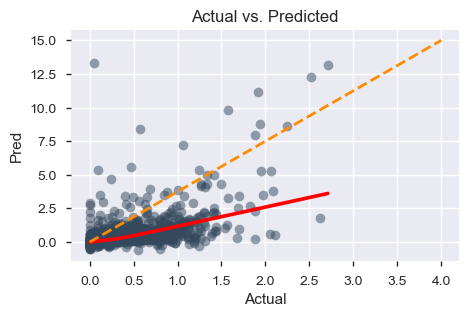

In [215]:
# Create figure space
plt.figure(figsize=(5,3))

# ### Actual vs Predicted
# sns.scatterplot(x='Actual',
#                 y='Pred',
#                 data=lm_df)

# Create scatterplot with loess
sns.regplot(x='Actual', y='Pred', data=lm_df,
            lowess=True, scatter=True, color='#34495e',
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.50})

# Plot diagonal line
plt.plot([0, 4], [0, 15], 'darkorange', lw=2, linestyle='--')

# Set plot features
plt.title('Actual vs. Predicted', fontsize=12)
plt.show()

If there data was linear, the shape would somewhat follow along the orange dotted line, but the distribution's trend is the red. Therefore, just from this one assumption, a linear algorithm would not be the best algorithm to use so we would need to resort to others.

### Normality of residuals - residual distribution (QQ-plot)

Assess how the data (error) depart from normality visually.

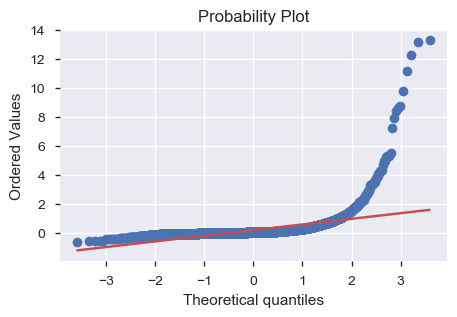

In [216]:
# Create figure space
plt.figure(figsize=(5,3))

### QQ-plot
stats.probplot(lm_df.Pred, plot=plt,)

plt.show()

Essentially, I can’t use a parametric approach like a linear regression but we did it just for practice. I have to consider non-parametric approaches that do not make assumptions about the residuals like a random forest. We could also add in other algorithms that we will be using to test which one will perform the best along with a "stacking" algorithm.

### Using make_pipeline() to simplify steps into 1 line

Pipeline is a combination of several functions into one, which makes cleaner code and less steps to take. So similar to how you make transform your train set and fit to predict, pipeline performs the entire sequence from different transformations (finding set of features, generating new features, and feature selection) of the data before applying the final estimator.

Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator and also encapsulates transformers and predictors inside.

With pipelines you can easily perform a grid-search over a set of params for each step of the meta-estimator.

In [217]:
# Linear regression
lm = LinearRegression()
lm = make_pipeline(lm).fit(X=X_train_scaled, y=y_train)
lm_score = cv_rmse(lm, X=X_test_scaled, y=y_test).mean()

''' cv_rmse replaces the code below
np.sqrt(-cross_val_score(make_pipeline(lm).fit(X=X_train_scaled, y=y_train), X_test_scaled, y_test, scoring='neg_mean_squared_error', cv=cv))
# lm_y_pred = lm.predict(X_test_scaled)
# lm_score = base_rmse(y_test, lm_y_pred)
'''

lm_score

3151449.58033827

Our CV score is incredibly high. I looked at each individual score and there were 2 splits that had an abnormally high error score which brought the mean up.

Here's a list of the algorithms to test we are going to test with. 

- Random Forest
- Gradient Boosting
- Lasso Regression
- Ridge Regression
- Elastic Net Regression
- Support Vector Regression
- Light Gradient Boosting
- Extreme Gradient Boosting

In [218]:
# Random forest
rf = RandomForestRegressor(n_estimators=100, random_state=seed)
rf_score = cv_rmse(rf).mean()

# Gradient Boosting
starttime = dt.datetime.now()
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.01,
                                random_state=100
                               )
gbr_score = cv_rmse(gbr).mean()
endtime = dt.datetime.now()
gbr_build_time = endtime-starttime

# Lasso CV
starttime = dt.datetime.now()
lasso_cv = make_pipeline(MinMaxScaler(), LassoCV(cv=cv, random_state=seed))
lasso_cv_score = cv_rmse(lasso_cv).mean()
endtime = dt.datetime.now()
lasso_cv_build_time = endtime-starttime

# Ridge CV
starttime = dt.datetime.now()
ridge_cv = make_pipeline(MinMaxScaler(), RidgeCV(cv=cv))
ridge_cv_score = cv_rmse(ridge_cv).mean()
endtime = dt.datetime.now()
ridge_cv_build_time = endtime-starttime

# GLMNET CV
starttime = dt.datetime.now()
glmnet_cv = make_pipeline(MinMaxScaler(), ElasticNetCV(cv=cv))
glmnet_cv_score = cv_rmse(glmnet_cv).mean()
endtime = dt.datetime.now()
glmnet_cv_build_time = endtime-starttime

# Support Vector
starttime = dt.datetime.now()
svr = make_pipeline(MinMaxScaler(), SVR())
svr_score = cv_rmse(svr).mean()
endtime = dt.datetime.now()
svr_build_time = endtime-starttime

# Light Gradient Boosting
starttime = dt.datetime.now()
lgbm = LGBMRegressor(objective='regression', 
                      learning_rate=0.01, 
                      n_estimators=100,
                      verbose=-1
                     )

lgbm_score = cv_rmse(lgbm).mean()
endtime = dt.datetime.now()
lgbm_build_time = endtime-starttime

# Extreme Gradient Boosting
starttime = dt.datetime.now()
xgb = XGBRegressor(learning_rate=0.01,
                    n_estimators=1000,
                    objective='reg:squarederror',
                    random_state=seed
                   )
xgb_score = cv_rmse(xgb).mean()
endtime = dt.datetime.now()
xgb_build_time = endtime-starttime

# Stacking with a XGBoost optimizer
starttime = dt.datetime.now()
stacking_generate = StackingCVRegressor(regressors=(rf, gbr, lasso_cv, ridge_cv, glmnet_cv, lgbm, xgb),
                                        meta_regressor=rf,
                                        use_features_in_secondary=True)
endtime = dt.datetime.now()
stacking_build_time = endtime-starttime

### Store the initial cross-validated model scores

In [219]:
# Create a dataframe to store the values and models
initial_scores_df = pd.DataFrame({'CV Score': [lm_score,
                                               rf_score,
                                               gbr_score,
                                               lasso_cv_score,
                                               ridge_cv_score,
                                               glmnet_cv_score,
                                               svr_score,
                                               lgbm_score,
                                               xgb_score]})

initial_scores_df.index = ['LM', 'RF', 'GBR', 'LASSO' ,'Ridge' ,'Elastic' ,'SVR' ,'LGBM' , 'XGB']
sorted_initial_scores_df = initial_scores_df.sort_values(by='CV Score', ascending=True)
sorted_initial_scores_df

,CV Score
RF,1.916097e-02
GBR,2.504367e-02
XGB,2.507775e-02
Ridge,3.017155e-02
LASSO,3.017723e-02
Elastic,3.017749e-02
LGBM,3.354890e-02
SVR,6.613088e-02
LM,3.151450e+06


### Fitting the new models after cross-validation

In [220]:
# Fit the new models so use for blending
starttime = dt.datetime.now()

print('Fitting stacking model...')
stack_gen_model = stacking_generate.fit(np.array(X_train_scaled), np.array(y_train))
print('Fitting linear model...')
lm_fit_model = lm.fit(X_train, y_train)
print('Fitting forest model...')
rf_fit_model = rf.fit(X_train, y_train)
print('Fitting gradient boosting model...')
gbr_fit_model = gbr.fit(X_train, y_train)
print('Fitting lasso model...')
lasso_fit_model = lasso_cv.fit(X_train, y_train)
print('Fitting ridge model...')
ridge_fit_model = ridge_cv.fit(X_train, y_train)
print('Fitting elastic net model...')
glmnet_fit_model = glmnet_cv.fit(X_train, y_train)
print('Fitting support vector model...')
svr_fit_model = svr.fit(X_train, y_train)
print('Fitting light gradient boosting model...')
lgb_fit_model = lgbm.fit(X_train, y_train)
print('Fitting extreme gradient boosting model...')
xgb_fit_model = xgb.fit(X_train, y_train)

endtime = dt.datetime.now()

print('Model Fitting Time Elapsed: {}'.format(endtime-starttime))

Fitting stacking model...
Fitting linear model...
Fitting forest model...
Fitting gradient boosting model...
Fitting lasso model...
Fitting ridge model...
Fitting elastic net model...
Fitting support vector model...
Fitting light gradient boosting model...
Fitting extreme gradient boosting model...
Model Fitting Time Elapsed: 0:04:21.747172


Great, now that we have fit all of our models with our training data, we could now attempt to produce a blended model of out of a handful of models together. 

In summary so far from beginning, here were the steps that we did:
1. Instantiate all of our models
2. Identify our evaluation metrics
3. Cross-validate our models and obtain scores to see if it was good enough
4. Create a stacked model out of a series of models
5. Fit our cross-validated models

Now we are at step 6!
6. Predict and evaluate our models with the creation of a blended model score (don't use .mean if we want plot a boxplot of scores to see score spread)
    - Will our blended model have a top score? For me, that's the goal of the stacked ensemble.
7. Results & Conclusion

In [223]:
# First, define the blending function get a score
def blend_models(X):
    '''
    Function will return predicted values from test data with weighted percentages per model
    '''

    return ((0.20 * stack_gen_model.predict(np.array(X))) + \
            (0.10 * ridge_fit_model.predict(X)) + \
            (0.08 * lasso_fit_model.predict(X)) + \
            (0.08 * glmnet_fit_model.predict(X)) + \
            (0.14 * gbr_fit_model.predict(X)) + \
            (0.13 * xgb_fit_model.predict(X)) + \
            (0.06 * lgb_fit_model.predict(X)) + \
            (0.05 * svr_fit_model.predict(X)) + \
            (0.16 * rf_fit_model.predict(X))
    )

### What's the blended model score?

In [224]:
print('Blended RMSE Score:')
print(base_rmse(y_test, blend_models(X_test)))
blended_score = base_rmse(y_test, blend_models(X_test))

Blended RMSE Score:
0.21206434155846646


### Store the scores

In [225]:
scorelist = {}

scorelist['LM']= lm_score
scorelist['RF']= rf_score
scorelist['GBR']= gbr_score
scorelist['Lasso']= lasso_cv_score
scorelist['Ridge']= ridge_cv_score
scorelist['Elastic']= glmnet_cv_score
scorelist['SVR']= svr_score
scorelist['LGBM']= lgbm_score
scorelist['XGB']= xgb_score
scorelist['Blend']= blended_score

# Create dataframe
model_names = [i for i in scorelist.keys()]
model_scores = [i for i in scorelist.values()]

scorelist_df = pd.DataFrame({'Model': model_names,
                             'Score': model_scores})

scorelist_df.sort_values(by='Score', ascending=True)

,Model,Score
1,RF,1.916097e-02
2,GBR,2.504367e-02
8,XGB,2.507775e-02
4,Ridge,3.017155e-02
3,Lasso,3.017723e-02
5,Elastic,3.017749e-02
7,LGBM,3.354890e-02
6,SVR,6.613088e-02
9,Blend,2.120643e-01
0,LM,3.151450e+06


### Plotting the Scores

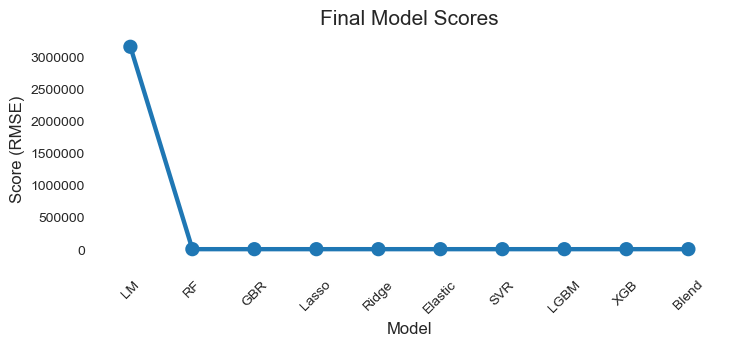

In [226]:
# Create figure space
sns.set_style('white')
plt.figure(figsize=(8,3))

# Create pointpoint or catplot
sns.pointplot(x='Model',
              y='Score',
              data=scorelist_df,
              height=5)

# Set plot features
plt.xticks(rotation='45')
plt.title('Final Model Scores', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score (RMSE)', fontsize=12)
plt.show()

### Feature importance

Which features are considered "important" in determining the predicted value to the model?

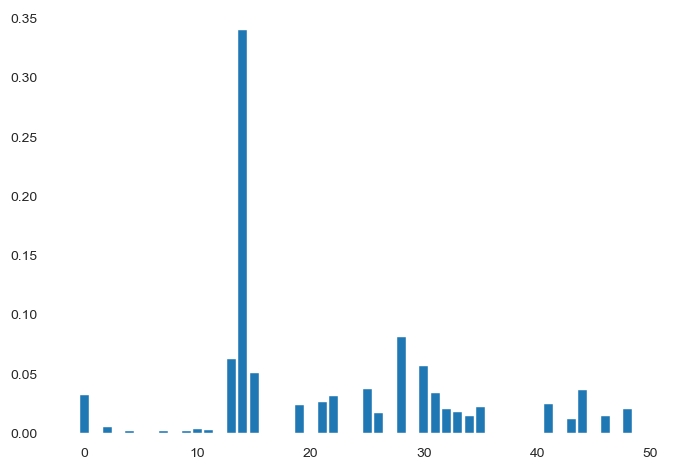

In [227]:
import matplotlib.pyplot as pyplot

# Use the feature_importances_ method from xgb
pyplot.bar(range(len(xgb_fit_model.feature_importances_)), xgb_fit_model.feature_importances_)
pyplot.show()

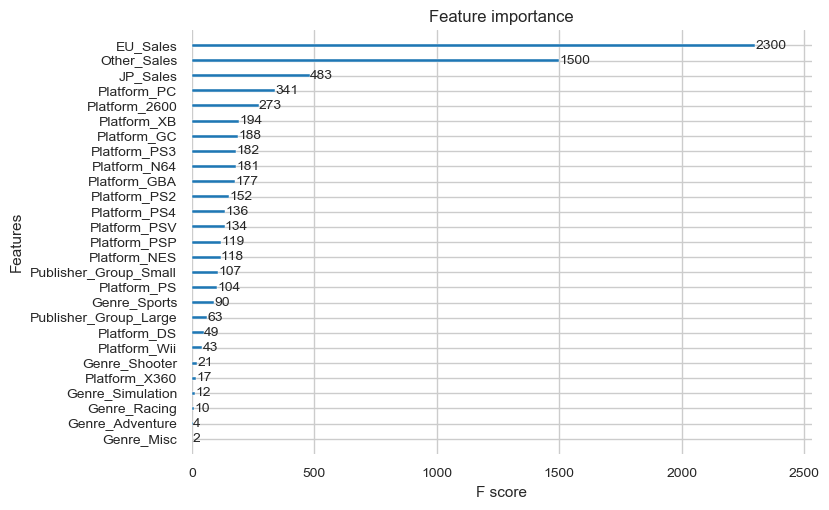

In [228]:
# Plot
plot_importance(xgb_fit_model)
pyplot.show()

In [230]:
# Get feature names
headers = X_train.columns

# Create a new function to capture feature importance for free models (RF, GB, XGB)
def feature_importance(model):
    
    importance = pd.DataFrame({'Feature': headers,
                               'Importance': np.round(model.feature_importances_,5)})
    
    importance = importance.sort_values(by='Importance', ascending=False).set_index('Feature')
    
    return importance

In [231]:
# Extreme gradient boosting tree
feature_importance(xgb_fit_model)

,Importance
Feature,
Other_Sales,0.34031
Platform_PC,0.08163
JP_Sales,0.06285
Platform_PS,0.05729
Platform_2600,0.05067
Platform_N64,0.03783
Platform_XB,0.03648
Platform_PS2,0.03433
EU_Sales,0.03274


In [232]:
# Random forest
feature_importance(rf_fit_model)

,Importance
Feature,
Other_Sales,0.63049
EU_Sales,0.11754
JP_Sales,0.04548
Platform_PC,0.03790
Platform_2600,0.01709
Platform_PS,0.01295
Platform_XB,0.01222
Platform_N64,0.01130
Platform_GC,0.00980


In [233]:
# Store top 20 features from xgb
xgb_top_features = list(feature_importance(xgb_fit_model).iloc[0:20,].index)

# Store top 20 features from rf
rf_top_features = list(feature_importance(rf_fit_model).iloc[0:20,].index)

### Saving our models

In [234]:
# # import pickle

# # Create file names for the models
# filenames = ['10-LM_model.sav', '10-RF_model.sav', '10-GBR_model.sav', '10-LASSO_model.sav' ,'10-Ridge_model.sav' ,
#              '10-Elastic_model.sav' ,'10-SVR_model.sav' ,'10-LGBM_model.sav' , '10-XGB_model.sav']

# all_models = [stack_gen_model, ridge_fit_model, lasso_fit_model, glmnet_fit_model, gbr_fit_model,
#               xgb_fit_model, lgbm_fit_model, svr_fit_model, rf_fit_model]

# # Loop through each model and save
# os.chdir('\\Models')
# for i in all_models:
#     pickle.dump(model[i], open(filenames[i], 'wb'))
# os.chdir('..')

### Loading our models

In [235]:
# import pickle
# # Load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

## Ending notes

I originally wanted to go through the algorithms being used here but I decided that was going to be a bit too long. I will actually make separate notebooks for the algorithms so it is easier to digest and specific just for that purpose. There are many different processes in how we could go from developing our models, cross-validating, testing, and evaluating. I will try to implement another way in the next notebook.

## More topics & steps that we did not go too much into

### Principal component analysis (dimensionality reduction)

Principal component analysis is an unsupervised algorithm, which is fundamentally a dimensionality reduction algorithm which is useful for noise filtering.

But first let's briefly go over the concept of __Curse of Dimensionality__. 

The term simply indicates that as the number of feature/dimensions grow, the amount of data we need to generalize accurately grows exponentially. Imagine that you have to find a penny. In a 1D field that's about 1 feet long, it wouldn't be too hard. How about changing it to a 2D field where it's about 1 feet long in width but the height is as tall as a skyscraper. It just got really difficult knowing that the space is a lot bigger once we added a second dimension. Now imagine changing that 2D into a 3D space, an actual skyscraper. Try finding that penny now because a single space problem just got exponentially harder. Good luck. Computational power increases, memory space needed increases, and the pain of going through every single combination is just plain difficult. That is the curse of dimensionality.

As stated by the author of the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow", _“...in most real-world problems training instances are not spread uniformly across all dimensions. You might have features that are constant while others are highly correlated which in the end makes all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.”_ — Aurélien Géron

Here's a picture below from Géron's book that depicts data in a 3D plane that is transformed into a 2D plane representation. After having the data unfold, it's a lot simpler to split.

More notes in additional link at the end.

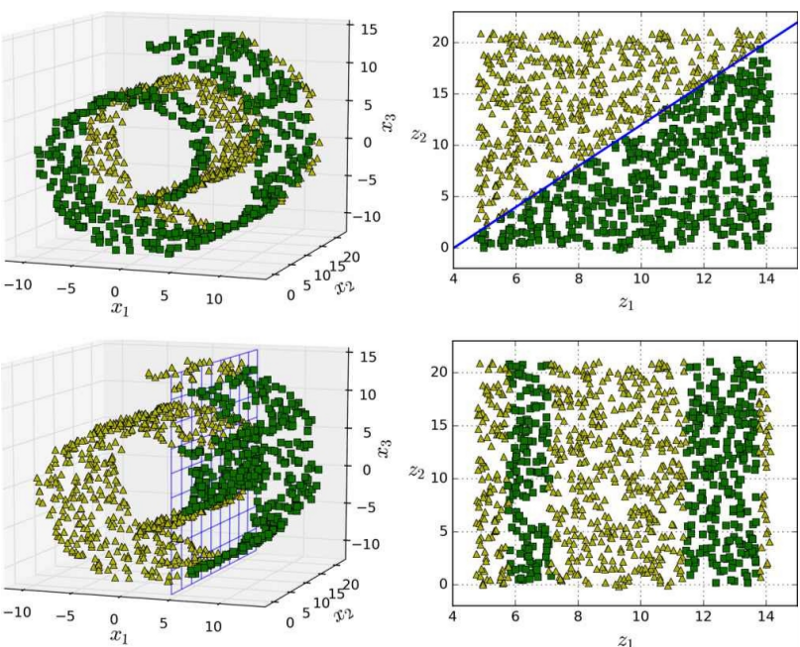

In [236]:
Image.open('..\\Images\\10-dimension.png')

In [237]:
# Define a PCA function to check features and choose top n components
def check_pca(X_train_scaled):
    # Check PCA
    pca = PCA().fit(X_train_scaled)

    # Plotting explained variance to determine how many components to include
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA Analysis')
    plt.show()

    # Sample code: Applying PCA, reduce features to top 20
    pca = PCA(n_components=20)
    X_train_scaled_pca = pca.fit_transform(X_train_scaled)
    X_test_scaled_pca = pca.transform(X_test_scaled)
    explained_variance = pca.explained_variance_ratio_

### Random forest hyperparameter tuning sample

We cross-validated and created our models but we did not do a grid search on the hyperparametrs to find the best ones. This is an additional step in finding the best values for our problem. 

What this step is essentially is that an algorithm would have a specific "knob" called a hyperparameter which is similar to a setting that you turn yourself or you can attempt to automate it. The knobs are changed to specifically to where it can perform the best.

In [238]:
# If we were to go in depth on hyperparameter tuning, we could use this function below
# Defining a function that will search and cross-validate scores
def rf_model_grid(X, y):
    '''
    Performs a grid search on random forest and chooses best parameters to fit tuned random forest and cross-validate
    Return cross-validated scores
    '''
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 500),
        },
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rf = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],  
                                random_state=False, 
                                verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rf, X, y, cv=3, scoring='neg_mean_absolute_error')

    return scores

__Additional Links__
- [Model Tuning CV](
https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/)
- [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
- [Saving models with Pickle](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)